# SC Cosmetics 

## Import Libaries

In [2]:
!pip install -q --upgrade pip
!pip install -q pyathena
!pip install -q imbalanced-learn
!pip install -q smclarify==0.1
!pip install -q --upgrade statsmodels
!pip install -q --upgrade threadpoolctl

import boto3
import sagemaker
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyathena import connect
from imblearn.over_sampling import SMOTE

from smclarify.bias import report
from typing import Dict
from collections import defaultdict

from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at 

## Copy Data from S3
https://sc-cosmetics.s3.amazonaws.com/chemicals-in-cosmetics/cosmetic_chemicals.csv

https://sc-cosmetics.s3.amazonaws.com/cosmetic-ingedients-ranking-pricing/cosmetics.csv

https://sc-cosmetics.s3.amazonaws.com/customer-propensity-to-purchase/customer.csv

In [3]:
# define the S3 bucket, role, and region
sess = sagemaker.Session()
bucket = "sc-cosmetics"  
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# define S3 paths for the source (public) and destination (private) locations
s3_public_path_chemicals = "s3://sc-cosmetics/chemicals-in-cosmetics"
s3_public_path_cosmetics = "s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing"
s3_public_path_customer = "s3://sc-cosmetics/customer-propensity-to-purchase"
s3_private_path = f"s3://{bucket}/"  
s3_private_path_chemicals = f"s3://{bucket}/chemicals-in-cosmetics"
s3_private_path_cosmetics = f"s3://{bucket}/cosmetic-ingredients-ranking-pricing"
s3_private_path_customer = f"s3://{bucket}/customer-propensity-to-purchase"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# copy data from the public S3 buckets to our private S3 buckets
!aws s3 cp --recursive $s3_public_path_chemicals/ $s3_private_path_chemicals/
!aws s3 cp --recursive $s3_public_path_cosmetics/ $s3_private_path_cosmetics/
!aws s3 cp --recursive $s3_public_path_customer/ $s3_private_path_customer/

copy: s3://sc-cosmetics/chemicals-in-cosmetics/cosmetic_chemicals.csv to s3://sc-cosmetics/chemicals-in-cosmetics/cosmetic_chemicals.csv
copy: s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing/cosmetics.csv to s3://sc-cosmetics/cosmetic-ingredients-ranking-pricing/cosmetics.csv
copy: s3://sc-cosmetics/customer-propensity-to-purchase/customer.csv to s3://sc-cosmetics/customer-propensity-to-purchase/customer.csv


In [5]:
# list files in private S3 bucket
print("Files in private S3 bucket - Chemicals:")
!aws s3 ls $s3_private_path_chemicals/

print("\nFiles in private S3 bucket - Cosmetics:")
!aws s3 ls $s3_private_path_cosmetics/

print("\nFiles in private S3 bucket - Customer:")
!aws s3 ls $s3_private_path_customer/

Files in private S3 bucket - Chemicals:
2024-03-31 22:44:30          0 
2024-04-06 03:28:54   24191162 cosmetic_chemicals.csv

Files in private S3 bucket - Cosmetics:
2024-04-06 03:28:55    1157561 cosmetics.csv

Files in private S3 bucket - Customer:
2024-04-06 03:28:56   35077586 customer.csv


In [6]:
# read files into pd df
chemicals_df = pd.read_csv(s3_private_path_chemicals + "/cosmetic_chemicals.csv")
cosmetics_df = pd.read_csv(s3_private_path_cosmetics + "/cosmetics.csv")
customer_df = pd.read_csv(s3_private_path_customer + "/customer.csv")

## Data Exploration

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
chemicals_df.head()

,ProductName,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,SubCategory,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalCount,Discontinued,ChemicalRemoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82.0
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023.0
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023.0
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82.0
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82.0


In [9]:
chemicals_df['PrimaryCategory'].value_counts() 

Makeup Products (non-permanent)      75827
Nail Products                        15347
Skin Care Products                    7683
Sun-Related Products                  4939
Bath Products                         3466
Hair Coloring Products                2061
Hair Care Products (non-coloring)     1620
Tattoos and Permanent Makeup          1477
Personal Care Products                 765
Fragrances                             654
Oral Hygiene Products                  525
Shaving Products                       222
Baby Products                           49
Name: PrimaryCategory, dtype: int64

In [10]:
cosmetics_df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,brand_id,product_id
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [11]:
cosmetics_df['Label'].value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [12]:
customer_df.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,NaN
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,NaN
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,NaN
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,119.0


Since the cosmetics dataframe exclusively comprises skincare items, our analysis will focus solely on skincare products and those associated with sun protection from the chemicals present in the cosmetic dataframe.

## Table Manipulation

### chemicals table

### cosmetics table

### customer table

## Create Athena Database

In [13]:
# athena database name
db_name = 'sc_cosmetics'

In [14]:
# S3 staging directory
s3_staging = "s3://{0}/athena/staging".format(bucket)

In [15]:
# create connection for athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging)

In [16]:
create_query = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(create_query, conn)

""


In [17]:
# create chemicals in cosmetics table
chem_table_name ='cosmetic_chemicals'

# chemical data S3 directory
chem_s3_dir = f's3://{bucket}/chemicals-in-cosmetics'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{chem_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{chem_table_name}(
                ProductName string,
                CompanyID int,
                CompanyName string,
                BrandName string,
                PrimaryCategoryID int,
                PrimaryCategory string,
                SubCategoryID int,
                SubCategory string,
                ChemicalID int,
                ChemicalName string,
                InitialDateReported date,
                MostRecentDateReported date,
                ChemicalCreatedAt date,
                ChemicalUpdatedAt date,
                ChemicalCount int,
                Discontinued int,
                ChemicalRemoved int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{chem_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [18]:
# view top 5 rows of chemical_cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{chem_table_name} LIMIT 5', conn)

,productname,companyid,companyname,brandname,primarycategoryid,primarycategory,subcategoryid,subcategory,chemicalid,chemicalname,initialdatereported,mostrecentdatereported,chemicalcreatedat,chemicalupdatedat,chemicalcount,discontinued,chemicalremoved,brand_id
0,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,Lip Color - Lipsticks Liners and Pencils,6,Titanium dioxide,2009-06-17,2013-08-28,2009-07-09,2009-07-09,1,1,0,82
1,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),4,Distillates (coal tar),2009-07-01,2009-07-01,2009-07-01,2009-07-01,2,0,0,1023
2,Glover's Medicated Shampoo,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,Hair Shampoos (making a cosmetic claim),5,Estragole,2009-07-01,2009-07-01,2009-07-02,2009-07-02,2,0,0,1023
3,PRECISION GLIMMER EYE LINER-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,Eyeliner/Eyebrow Pencils,7,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,0,0,82
4,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,Lip Gloss/Shine,8,Titanium dioxide,2009-07-09,2013-08-28,2009-07-09,2009-07-09,1,1,0,82


In [19]:
# create subquery with the skin care products and sun-related products 

skinproducts_sub = ["Sun-Related Products", "Skin Care Products "]
in_clause = "', '".join(skinproducts_sub)

sub_query = f"""
            (
            SELECT *
            FROM sc_cosmetics.cosmetic_chemicals
            WHERE PrimaryCategory IN ('{in_clause}')
            )
"""

# create a new table using the subquery
cosmetic_chemicals_sub = f"""
                         CREATE TABLE IF NOT EXISTS {db_name}.cosmetic_chemicals_sub AS {sub_query}
                         """

# Execute the create table query
with conn.cursor() as cursor:
    cursor.execute(cosmetic_chemicals_sub)

In [20]:
# create cosmetics table
cos_table_name ='cosmetics'

# cosmetics data S3 directory
cos_s3_dir = f's3://{bucket}/cosmetic-ingredients-ranking-pricing'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cos_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cos_table_name}(
                Label string,
                Brand string,
                Name string,
                Price float,
                Rank float,
                Ingredients string,
                Combination int,
                Dry int,
                Normal int,
                Oily int,
                Sensitive int,
                product_id int, 
                brand_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cos_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [21]:
# view top 5 rows of cosmetics table
pd.read_sql(f'SELECT * FROM {db_name}.{cos_table_name} LIMIT 5', conn)

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id
0,Moisturizer,LA MER,Crème de la Mer,175.0,4.1,Algae (Seaweed) Extract- Mineral Oil- Petrolat...,1,1,1,1,1,64,1
1,Moisturizer,SK-II,Facial Treatment Essence,179.0,4.1,Galactomyces Ferment Filtrate (Pitera)- Butyle...,1,1,1,1,1,95,2
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68.0,4.4,Water- Dicaprylyl Carbonate- Glycerin- Ceteary...,1,1,1,1,0,29,3
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175.0,3.8,Algae (Seaweed) Extract- Cyclopentasiloxane- P...,1,1,1,1,1,64,4
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38.0,4.1,Water- Snail Secretion Filtrate- Phenyl Trimet...,1,1,1,1,1,49,5


In [22]:
# create customer table
cust_table_name ='customer'

# customer data S3 directory
cust_s3_dir = f's3://{bucket}/customer-propensity-to-purchase'

# drop table if it already exists
drop_query = f'DROP TABLE IF EXISTS {db_name}.{cust_table_name}'
pd.read_sql(drop_query, conn)

# create table
create_query = f"""
                CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{cust_table_name}(
                UserID string,
                basket_icon_click int,
                basket_add_list int,
                basket_add_detail int,
                sort_by int,
                account_page_click int,
                detail_wishlist_add int,
                list_size_dropdown int,
                closed_minibasket_click int,
                checked_delivery_detail int,
                checked_returns_detail int,
                sign_in int,
                saw_checkout int,
                saw_delivery int,
                saw_homepage int,
                device_mobile int,
                device_computer int,
                device_tablet int,
                returning_user int,
                loc_uk int,
                ordered int,
                product_id int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{cust_s3_dir}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_query, conn)

""


In [23]:
# view top 5 rows of customer table
pd.read_sql(f'SELECT * FROM {db_name}.{cust_table_name} LIMIT 5', conn)

,userid,basket_icon_click,basket_add_list,basket_add_detail,sort_by,account_page_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,product_id
0,84d0-82c61917-84d0-41aa-a04c-607845,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,None
1,68dc-82c6b1c9-68dc-b168-8425-91412,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,None
2,8786-82c1eb1b-8786-411b-bd14-548509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,None
3,1a2b-82c6b429-1a2b-4c1d-b019-845548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,None
4,c752-82c6b546-c752-47a3-a5bd-104606,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,None


In [24]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,sc_cosmetics


In [25]:
# define query to show tables in db
show_tables_query = f"SHOW TABLES IN {db_name}"

# execute query+ display tables in db
tables_df = pd.read_sql(show_tables_query, conn)
tables_df

,tab_name
0,cosmetic_chemicals
1,cosmetic_chemicals_sub
2,cosmetics
3,customer
4,sc_cosmetics_app
5,skin_products


In [26]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [27]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [28]:
# define SQL query
query = """
        SELECT cu.UserID,
               cu.basket_icon_click,
               cu.basket_add_list,
               cu.account_page_click,
               cu.detail_wishlist_add,
               cu.saw_checkout,
               cu.device_mobile,
               cu.device_computer, 
               cu.device_tablet,
               cu.returning_user,
               cu.ordered,
               c.*,
               ccc.PrimaryCategory,
               ccc.SubCategory,
               ccc.ChemicalName,
               ccc.ChemicalCount,
               ccc.Discontinued,
               ccc.ChemicalRemoved
        FROM sc_cosmetics.customer cu
        INNER JOIN sc_cosmetics.cosmetics c ON cu.product_id = c.product_id
        INNER JOIN sc_cosmetics.cosmetic_chemicals_sub ccc ON c.brand_id = ccc.brand_id;
        """

In [29]:
sc_df = pd.read_sql(query, conn)

In [30]:
sc_df.sample(n=10, random_state=42)

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
5297,d69d-76383562-d69d-4658-957a-813291,1,0,0,0,1,0,1,0,0,1,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4.3,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1.0,1,0,1,108,886,Sun-Related Products,Indoor Tanning Products,Titanium dioxide,1.0,0.0,0.0
21579,7456-c6d1cd7c-7456-4571-8852-260084,1,1,0,0,1,1,0,0,1,1,Cleanser,CAUDALIE,Vinopure Natural Salicylic Acid Pore Minimizin...,28.0,3.8,*Plant origin.,1,0.0,1,1,1,15,352,Skin Care Products,Skin Cleansers,Titanium dioxide,1.0,0.0,0.0
6778,9bd6-6021e915-9bd6-405a-9316-644765,0,0,0,0,1,0,1,0,0,1,Moisturizer,LANCÔME,Rénergie Lift Multi-Action Sunscreen Broad Spe...,99.0,3.9,Water- Dimethicone- Glycerin- Hydrogenated Pol...,1,1.0,1,1,1,66,249,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,2.0,0.0,0.0
33102,7cc2-b06b0657-7cc2-404d-b4bc-622182,0,0,0,0,1,1,0,0,1,1,Sun protect,CLARINS,UV PLUS Anti-Pollution Sunscreen Multi-Protect...,45.0,4.1,Visit the Clarins boutique,0,0.0,0,0,0,17,1318,Skin Care Products,Other Skin Care Product,Titanium dioxide,1.0,0.0,0.0
31710,2757-32b18873-2757-4565-b4d7-533137,1,1,0,0,1,1,0,0,1,1,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4.3,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1.0,1,0,1,108,886,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
50550,2907-8251e188-2907-4507-b759-358922,0,0,0,0,1,0,0,1,0,1,Sun protect,SHISEIDO,Urban Environment Tinted UV Protector Broad Sp...,34.0,4.3,Visit the Shiseido boutique,0,0.0,0,0,0,94,1319,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
29368,7ac9-b84748d7-7ac9-4d1e-b712-706958,0,0,0,0,1,1,0,0,1,1,Face Mask,SEPHORA COLLECTION,Peel-off Mask,20.0,3.6,Water- Talc- Alcohol Denat.- Polyvinyl Alcohol...,1,1.0,1,1,0,93,1065,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Methyleugenol,4.0,0.0,0.0
36767,6763-24627baa-6763-47b7-8137-466884,1,0,0,0,1,0,0,1,1,1,Cleanser,FRESH,Rose Cleansing Foam,29.0,3.6,Water- Butylene Glycol- Decyl Glucoside- Glyce...,1,1.0,1,1,1,40,484,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
33945,ac86-35068647-ac86-b109-ad74-685747,0,1,0,0,1,0,1,0,0,1,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4.3,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1.0,1,0,1,108,886,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Coffee,1.0,0.0,0.0
46855,876a-14a79776-876a-4015-a858-154210,1,0,0,0,1,1,0,0,1,1,Treatment,TATA HARPER,Resurfacing Serum,88.0,4.2,Hordeum Vulgare Leaf Juice*- Propanediol- Aqua...,1,1.0,1,1,1,105,674,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1.0,1.0,0.0


## Exploratory Data Analysis (EDA)

In [31]:
# inspect df 
print('Number of Rows:', sc_df.shape[0])
print('Number of Columns:', sc_df.shape[1], '\n')

sc_df.info()

Number of Rows: 51784
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51784 entries, 0 to 51783
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               51784 non-null  object 
 1   basket_icon_click    51784 non-null  int64  
 2   basket_add_list      51784 non-null  int64  
 3   account_page_click   51784 non-null  int64  
 4   detail_wishlist_add  51784 non-null  int64  
 5   saw_checkout         51784 non-null  int64  
 6   device_mobile        51784 non-null  int64  
 7   device_computer      51784 non-null  int64  
 8   device_tablet        51784 non-null  int64  
 9   returning_user       51784 non-null  int64  
 10  ordered              51784 non-null  int64  
 11  label                51784 non-null  object 
 12  brand                51784 non-null  object 
 13  name                 51784 non-null  object 
 14  price                51400 non-null  flo

### Identifying and Removing Null Values

In [32]:
sc_df.isnull().sum()

UserID                   0
basket_icon_click        0
basket_add_list          0
account_page_click       0
detail_wishlist_add      0
saw_checkout             0
device_mobile            0
device_computer          0
device_tablet            0
returning_user           0
ordered                  0
label                    0
brand                    0
name                     0
price                  384
rank                   384
ingredients              0
combination              0
dry                    384
normal                   0
oily                     0
sensitive                0
product_id               0
brand_id                 0
PrimaryCategory          0
SubCategory              0
ChemicalName             0
ChemicalCount          615
Discontinued            63
ChemicalRemoved         63
dtype: int64

In [33]:
# calculate missing values as a percentage of total data 
missing_percentage = (sc_df.isnull().sum() / len(sc_df)) * 100 # convert to percentage 
missing_percentage = missing_percentage.sort_values(ascending=False) # place in ascending order

print('Missing Value Percentage per Column:')
print(missing_percentage)

Missing Value Percentage per Column:
ChemicalCount          1.187626
rank                   0.741542
price                  0.741542
dry                    0.741542
Discontinued           0.121659
ChemicalRemoved        0.121659
device_mobile          0.000000
device_computer        0.000000
basket_add_list        0.000000
account_page_click     0.000000
ChemicalName           0.000000
SubCategory            0.000000
PrimaryCategory        0.000000
brand_id               0.000000
product_id             0.000000
sensitive              0.000000
oily                   0.000000
normal                 0.000000
detail_wishlist_add    0.000000
combination            0.000000
ingredients            0.000000
basket_icon_click      0.000000
saw_checkout           0.000000
name                   0.000000
brand                  0.000000
label                  0.000000
ordered                0.000000
returning_user         0.000000
device_tablet          0.000000
UserID                 0.000000
dty

In [34]:
# impute values with rows missing less than 20% data using mode 
low_missing_cols = ['ChemicalCount', 'price', 'rank', 'dry','ChemicalRemoved', 'Discontinued']
for col in low_missing_cols:
    sc_df[col] = sc_df[col].fillna(sc_df[col].mode()[0])

In [35]:
sc_df.isnull().sum() # confrim misisng values are handles 

UserID                 0
basket_icon_click      0
basket_add_list        0
account_page_click     0
detail_wishlist_add    0
saw_checkout           0
device_mobile          0
device_computer        0
device_tablet          0
returning_user         0
ordered                0
label                  0
brand                  0
name                   0
price                  0
rank                   0
ingredients            0
combination            0
dry                    0
normal                 0
oily                   0
sensitive              0
product_id             0
brand_id               0
PrimaryCategory        0
SubCategory            0
ChemicalName           0
ChemicalCount          0
Discontinued           0
ChemicalRemoved        0
dtype: int64

In [36]:
sc_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,a796-82d16b78-a796-4676-a643-80134,0,0,0,0,1,0,1,0,0,1,Cleanser,LANEIGE,Essential Power Skin Toner for Combination to ...,28.0,4.4,Water- Alcohol- Glycereth-26- Dipropylene Glyc...,1,0.0,0,1,0,67,445,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
1,a796-82d16b78-a796-4676-a643-80134,0,0,0,0,1,0,1,0,0,1,Cleanser,LANEIGE,Essential Power Skin Toner for Combination to ...,28.0,4.4,Water- Alcohol- Glycereth-26- Dipropylene Glyc...,1,0.0,0,1,0,67,445,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0
2,a796-82d16b78-a796-4676-a643-80134,0,0,0,0,1,0,1,0,0,1,Cleanser,LANEIGE,Essential Power Skin Toner for Combination to ...,28.0,4.4,Water- Alcohol- Glycereth-26- Dipropylene Glyc...,1,0.0,0,1,0,67,445,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,2.0,0.0,0.0
3,a796-82d16b78-a796-4676-a643-80134,0,0,0,0,1,0,1,0,0,1,Cleanser,LANEIGE,Essential Power Skin Toner for Combination to ...,28.0,4.4,Water- Alcohol- Glycereth-26- Dipropylene Glyc...,1,0.0,0,1,0,67,445,Skin Care Products,Skin Moisturizers (making a cosmetic claim),Titanium dioxide,2.0,0.0,0.0
4,a796-82d16b78-a796-4676-a643-80134,0,0,0,0,1,0,1,0,0,1,Cleanser,LANEIGE,Moisturizing Foam Cleanser,23.0,3.8,Water- Glycerin- Stearic Acid- Myristic Acid- ...,1,1.0,1,0,1,67,441,Skin Care Products,Acne Products (making a cosmetic claim),Titanium dioxide,1.0,0.0,0.0


In [37]:
sc_df['ChemicalName'].value_counts() # chemicals present in cosmetics 

Titanium dioxide                       42372
Triethanolamine                         1902
Vitamin A palmitate                      777
Butylated hydroxyanisole                 775
Retinol                                  700
Retinyl palmitate                        601
Coffea arabica extract                   522
Trade Secret                             518
Caffeine                                 333
"Titanium dioxide (airborne              322
Mica                                     310
Coffee                                   285
Estragole                                252
Oil Orange SS                            196
Cocamide diethanolamine                  185
Methyleugenol                            170
Avobenzone                               161
Ginkgo biloba extract                    160
Cosmetic talc                            153
beta-Myrcene                             138
"Silica                                  115
"Mineral oils                             92
Toluene   

In [38]:
sc_df.shape #30 columns and 53325 rows of data 

(51784, 30)

### Visualizations 

#### Histograms

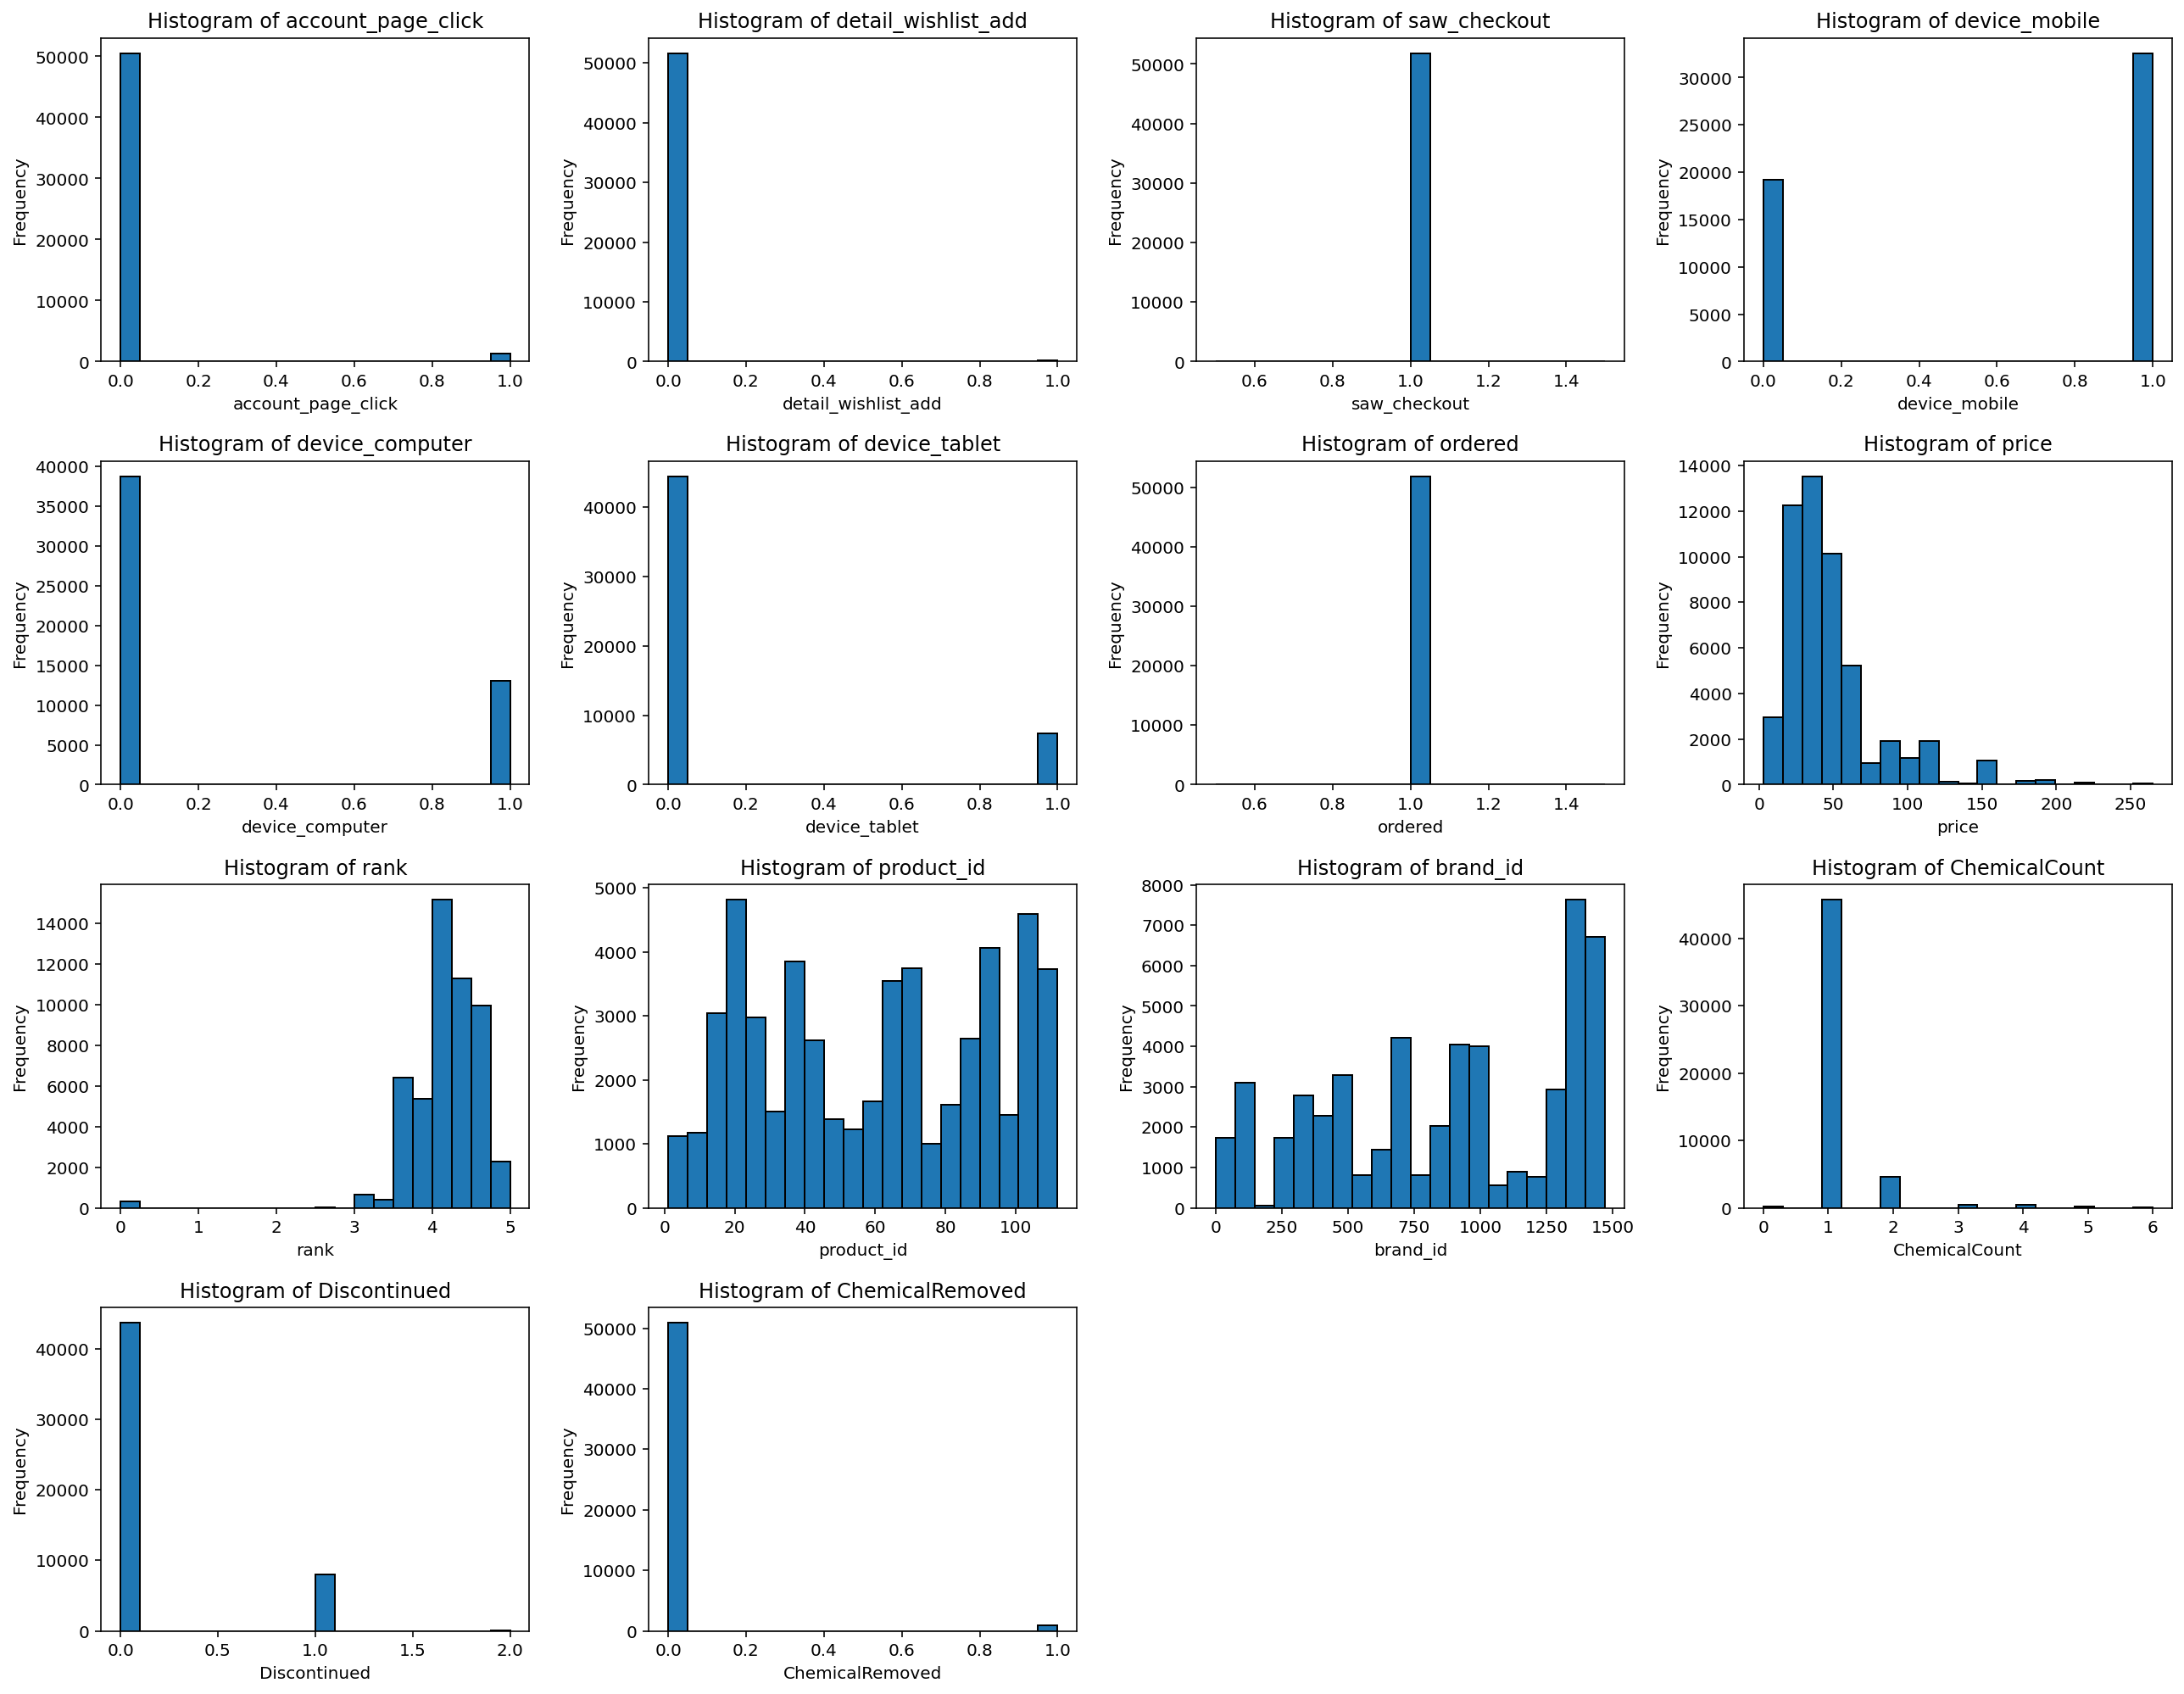

In [39]:
# list numerical predictors for histograms
predictors = [
    'account_page_click', 'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure
num_cols = 4
num_rows = (len(predictors) - 1) // num_cols + 1
plt.figure(figsize=(18, 14))  

# create histograms 
for i, predictor in enumerate(predictors):
    plt.subplot(num_rows, num_cols, i + 1)  
    plt.hist(sc_df[predictor], bins=20, edgecolor='black')
    plt.title(f'Histogram of {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

#### Box Plots

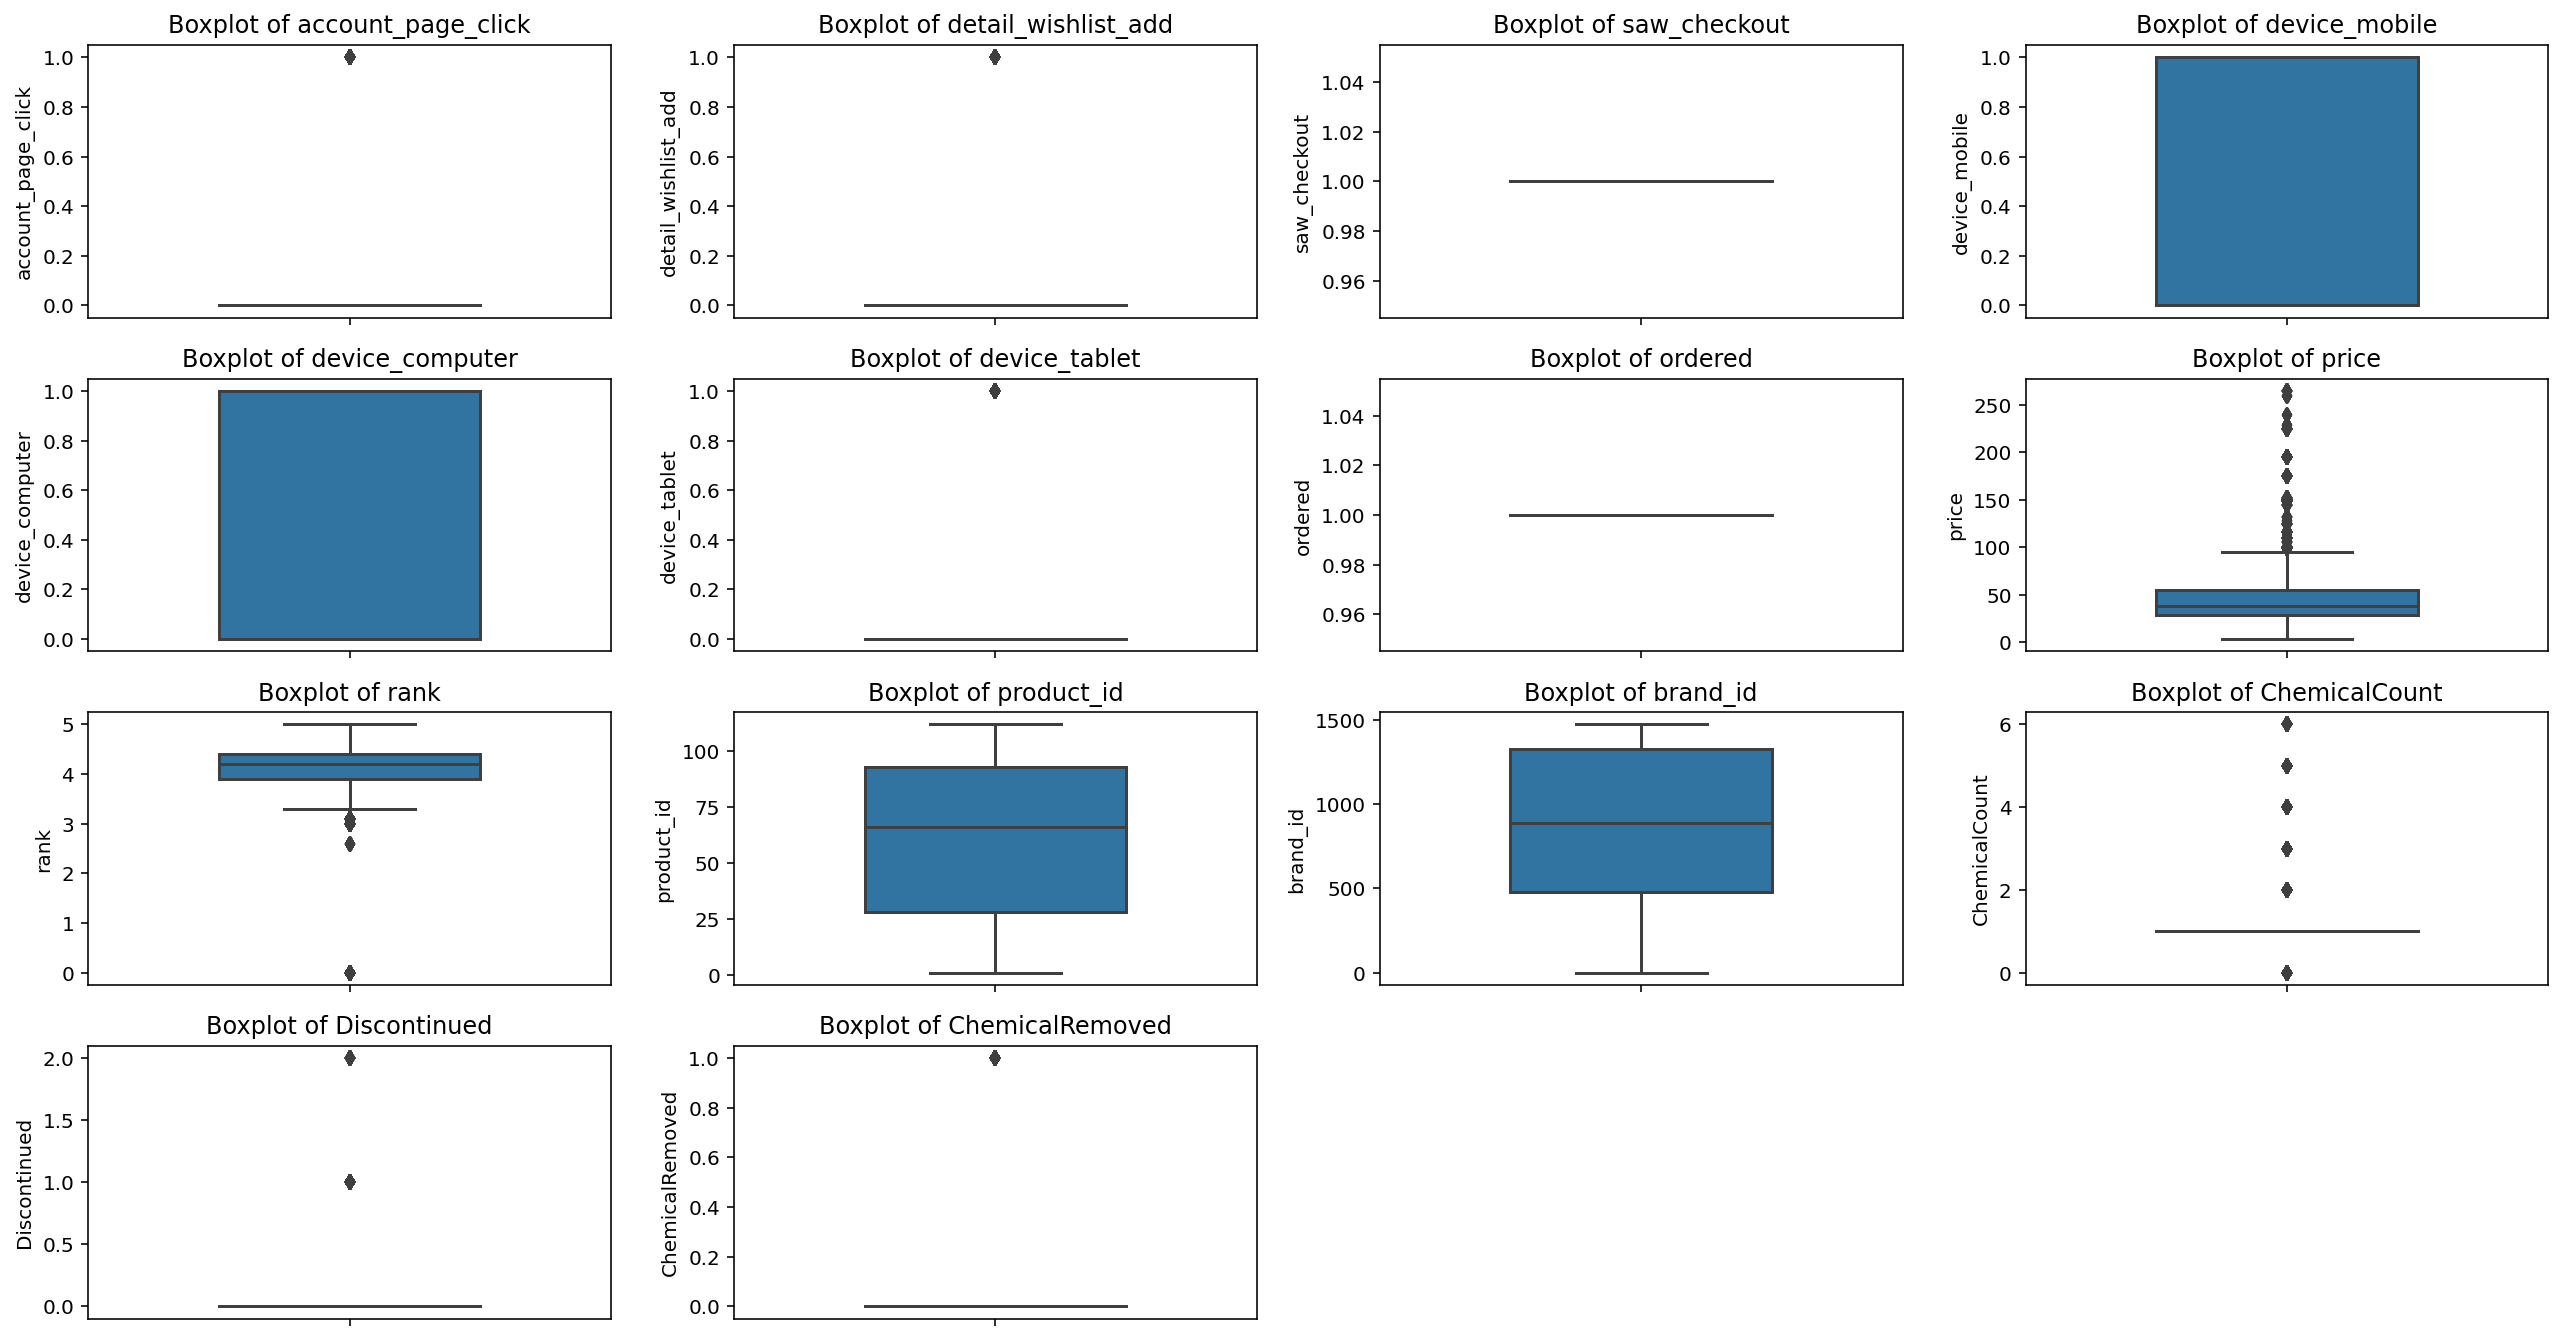

In [40]:
# list numerical predictors to create boxplots 
predictors = numerical_predictors = [
    'account_page_click','detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'ordered', 'price', 'rank', 'product_id', 
    'brand_id', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved'
]

# create figure for boxplots subplots 
plt.figure(figsize=(18, 14))  

# create boxplots for each predictor
for i, predictor in enumerate(predictors):
    plt.subplot(6, 4, i + 1)  
    sns.boxplot(data=sc_df, y=predictor, width=0.5)
    plt.title(f'Boxplot of {predictor}')
    plt.ylabel(predictor)

plt.tight_layout()  
plt.show()

#### Bar Plots 

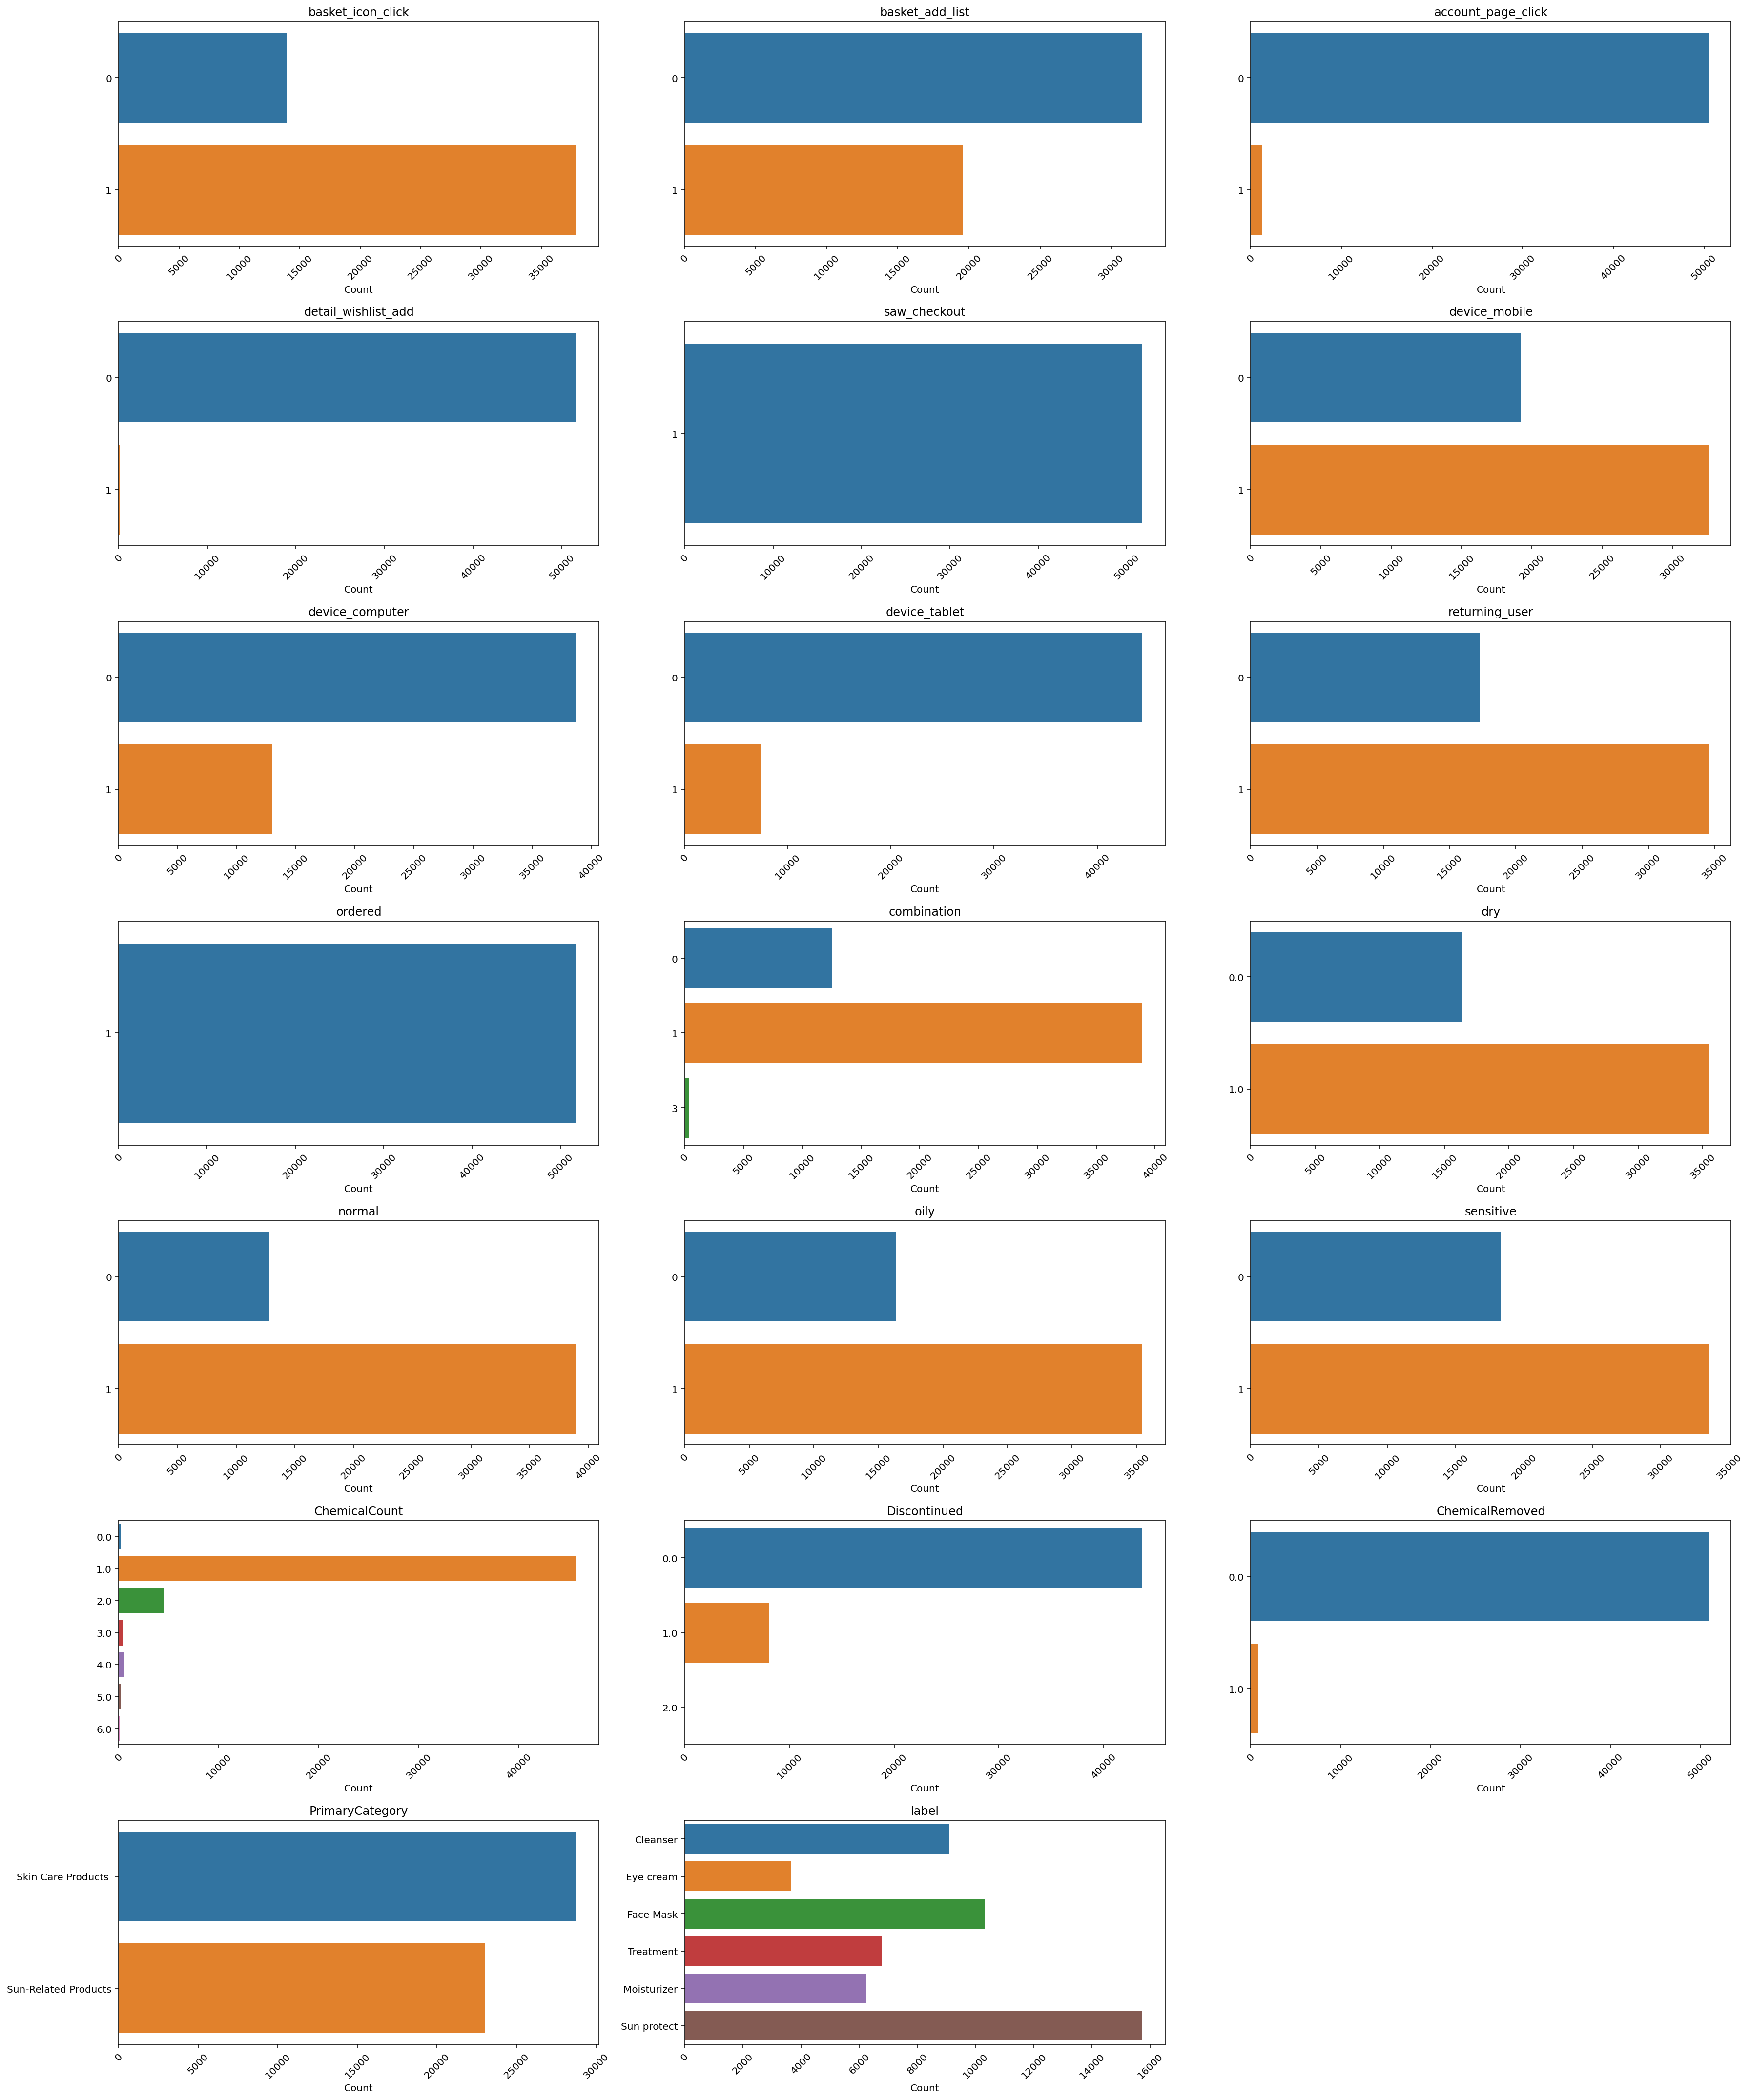

In [41]:
# list of selected columns for bar plot 
selected_columns = [
    'basket_icon_click', 'basket_add_list', 'account_page_click', 
    'detail_wishlist_add', 'saw_checkout', 'device_mobile', 
    'device_computer', 'device_tablet', 'returning_user', 
    'ordered', 'combination', 'dry', 'normal', 'oily', 'sensitive', 
    'ChemicalCount', 'Discontinued', 'ChemicalRemoved','PrimaryCategory', 'label'
]

# calculate the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (len(selected_columns) - 1) // num_cols + 1

# create subplots and flatten axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))
axes = axes.flatten()

# iterate through selected columns and create horizontal countplots
for i, column in enumerate(selected_columns):
    sns.countplot(data=sc_df, y=column, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  

    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

# remove empty subplots
for i in range(len(selected_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Class Imbalance 
#### ('ordered' and 'saw_checkout')

In [42]:
# check distribution of classes before adding class
print("\nBefore balancing:")
print(sc_df['ordered'].value_counts())
print(sc_df['saw_checkout'].value_counts())


Before balancing:
1    51784
Name: ordered, dtype: int64
1    51784
Name: saw_checkout, dtype: int64


In [43]:
# shuffle df to ensure randomness
sc_shuffled = sc_df.sample(frac=1)
sc_shuffled['ChemicalCount'] = sc_shuffled['ChemicalCount'].astype(int)

# define columns to balance 
columns_to_balance = ['ordered', 'saw_checkout']

# calculate number of records for 'saw_checkout' class 1 to maintain 60% balance
num_records_to_change_saw_checkout = int(len(sc_shuffled[sc_shuffled['saw_checkout'] == 1]) * 0.6)
records_to_change_saw_checkout = sc_shuffled[sc_shuffled['saw_checkout'] == 1].head(num_records_to_change_saw_checkout)
records_to_change_saw_checkout['saw_checkout'] = 0

# update df 
sc_shuffled.loc[records_to_change_saw_checkout.index, 'saw_checkout'] = records_to_change_saw_checkout['saw_checkout']


# define threshold for chemical count to determine class imbalance
chemical_count_threshold = 1

# calculate the number of records to change for 'ordered' class 1 based on chemical count 
num_records_to_change_ordered = int(len(sc_shuffled[(sc_shuffled['ordered'] == 1) & 
                                                    (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)]))

# select records where 'ordered' = 1 and chemical count does not exceed the threshold
records_to_change_ordered = sc_shuffled[(sc_shuffled['ordered'] == 1) & 
                                        (sc_shuffled['ChemicalCount'] <= chemical_count_threshold)].head(num_records_to_change_ordered)
records_to_change_ordered['ordered'] = 0

# update df 
sc_shuffled.loc[records_to_change_ordered.index, 'ordered'] = records_to_change_ordered['ordered']

In [44]:
# check distribution of classes after adding class
print("\nAfter balancing:")
print(sc_shuffled ['saw_checkout'].value_counts())
print(sc_shuffled ['ordered'].value_counts())


After balancing:
0    31070
1    20714
Name: saw_checkout, dtype: int64
0    45960
1     5824
Name: ordered, dtype: int64


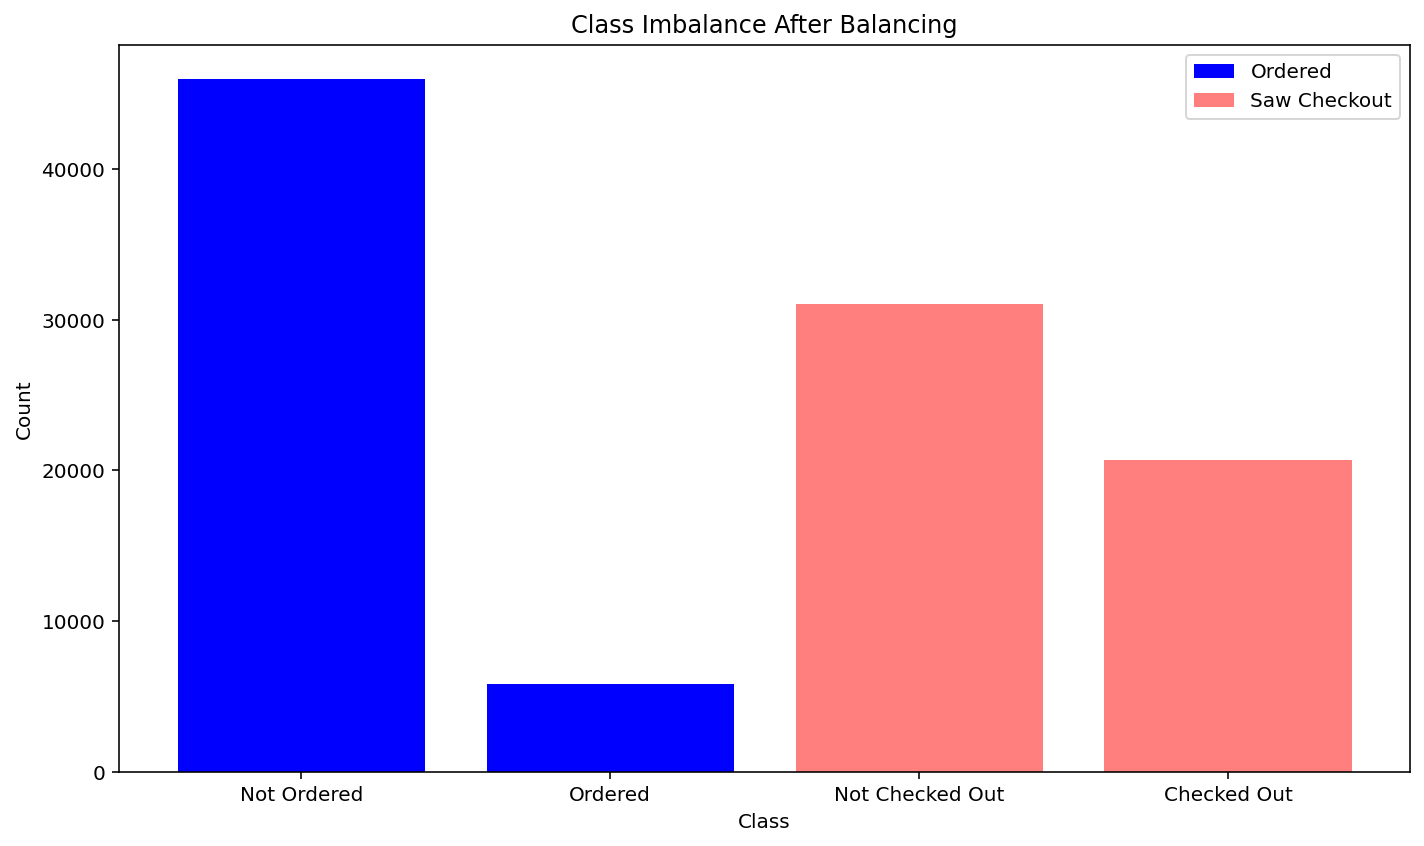

In [45]:
plt.figure(figsize=(10, 6))

# bar plot for 'ordered' column
plt.bar(['Not Ordered', 'Ordered'], sc_shuffled['ordered'].value_counts(), color='blue', label='Ordered')

# bar plot for 'saw_checkout' column
plt.bar(['Not Checked Out', 'Checked Out'], sc_shuffled['saw_checkout'].value_counts(), color='red', label='Saw Checkout', alpha=0.5)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance After Balancing')
plt.legend()
plt.tight_layout()

plt.show()

In [46]:
checkout_distribution = sc_shuffled['saw_checkout'].value_counts(normalize=True)
print("Class Distribution for Saw Check Out:\n", checkout_distribution)

ordered_distribution = sc_shuffled['ordered'].value_counts(normalize=True)
print("Class Distribution for Ordered:\n", ordered_distribution)

Class Distribution for Saw Check Out:
 0    0.599992
1    0.400008
Name: saw_checkout, dtype: float64
Class Distribution for Ordered:
 0    0.887533
1    0.112467
Name: ordered, dtype: float64


In [47]:
balanced_df = sc_shuffled.copy()
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51784 entries, 25076 to 41510
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               51784 non-null  object 
 1   basket_icon_click    51784 non-null  int64  
 2   basket_add_list      51784 non-null  int64  
 3   account_page_click   51784 non-null  int64  
 4   detail_wishlist_add  51784 non-null  int64  
 5   saw_checkout         51784 non-null  int64  
 6   device_mobile        51784 non-null  int64  
 7   device_computer      51784 non-null  int64  
 8   device_tablet        51784 non-null  int64  
 9   returning_user       51784 non-null  int64  
 10  ordered              51784 non-null  int64  
 11  label                51784 non-null  object 
 12  brand                51784 non-null  object 
 13  name                 51784 non-null  object 
 14  price                51784 non-null  float64
 15  rank                 51784 non-n

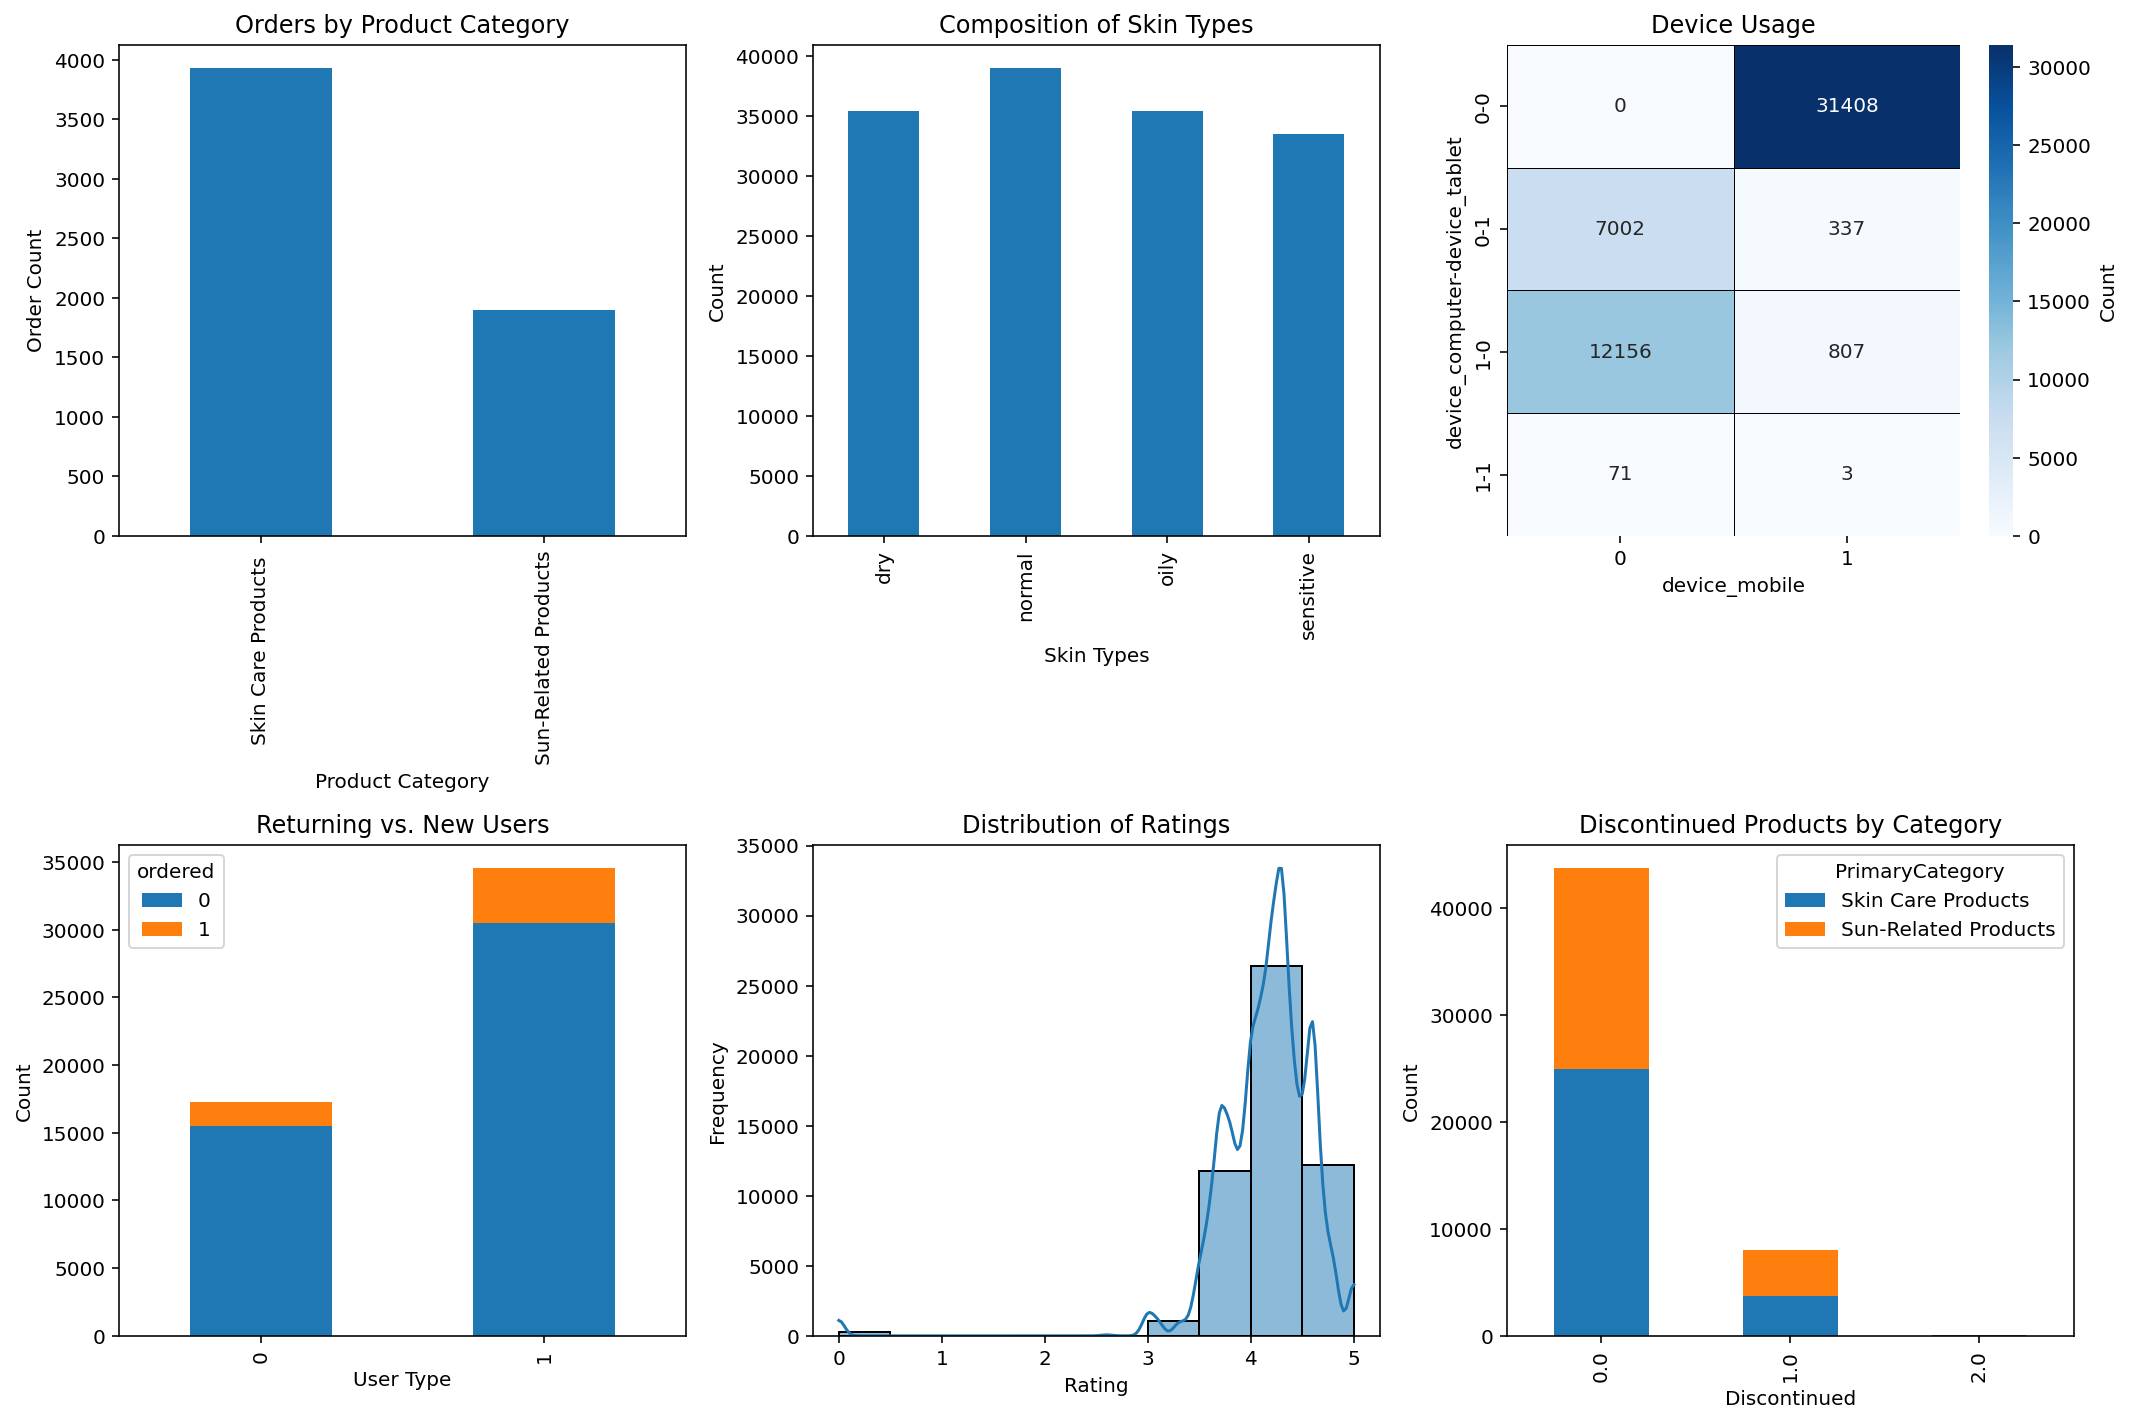

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# count of ordered by product category
order_count_by_category = balanced_df.groupby('PrimaryCategory')['ordered'].sum()
order_count_by_category.plot(kind='bar', ax=axs[0, 0], 
                             xlabel='Product Category', ylabel='Order Count', 
                             title='Orders by Product Category')

# composition of skin types
skin_type_counts = balanced_df[['dry', 'normal', 'oily', 'sensitive']].sum()
skin_type_counts.plot(kind='bar', stacked=True, ax=axs[0, 1], 
                      xlabel='Skin Types', ylabel='Count', 
                      title='Composition of Skin Types')

# device usage 
device_usage = balanced_df[['device_computer', 'device_tablet', 'device_mobile']].astype(int)
device_usage_counts = device_usage.groupby(device_usage.columns.tolist()).size().unstack(fill_value=0)
sns.heatmap(device_usage_counts, ax=axs[0, 2], cmap="Blues", annot=True, fmt="d",
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='black')
axs[0, 2].set_title('Device Usage')

# returning vs new users 
returning_new_users = pd.crosstab(balanced_df['returning_user'], 
                                  balanced_df['ordered'])

returning_new_users.plot(kind='bar', stacked=True, ax=axs[1, 0], 
                         xlabel='User Type', ylabel='Count', 
                         title='Returning vs. New Users')

# distribution of ratings 
sns.histplot(data=balanced_df, x='rank', bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Ratings')

# discontinued products 
discontinued_category_counts = pd.crosstab(index=balanced_df['Discontinued'], 
                                           columns=balanced_df['PrimaryCategory'])

discontinued_category_counts.plot(kind='bar', stacked=True, ax=axs[1, 2], 
                                  xlabel='Discontinued', ylabel='Count', 
                                  title='Discontinued Products by Category')

plt.tight_layout()
plt.show()

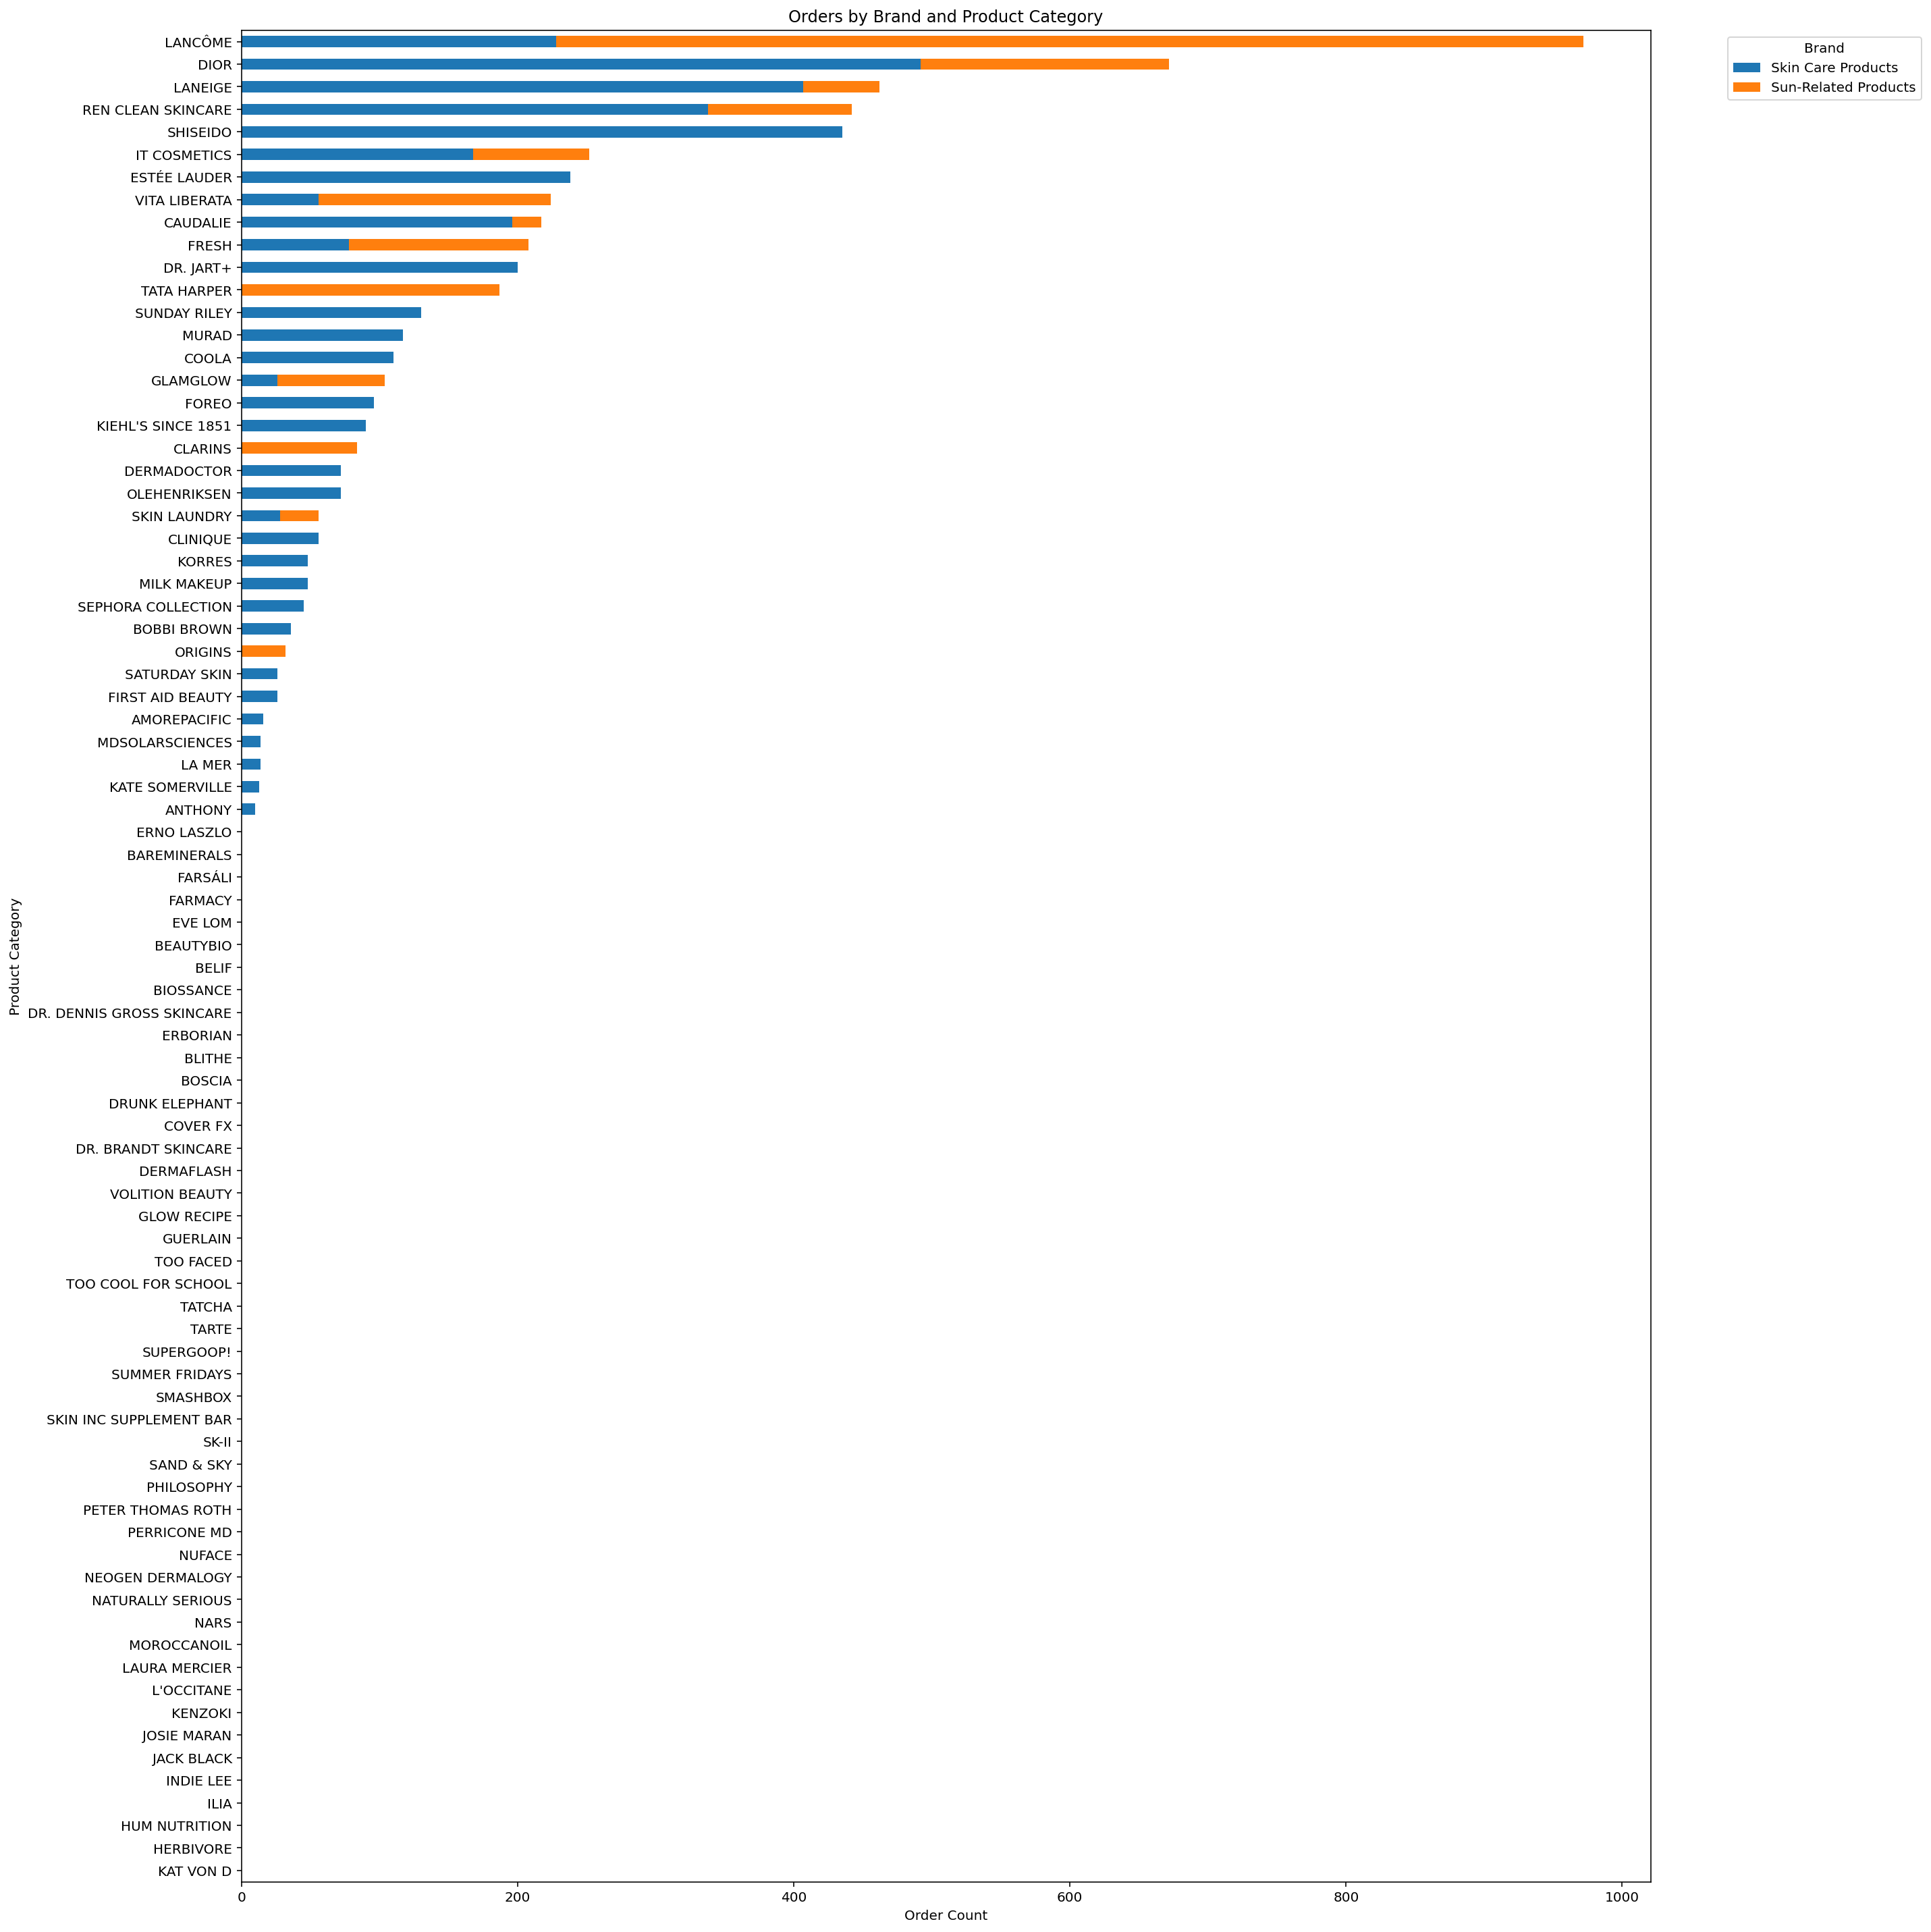

In [49]:
#  order count by brand and product category
order_count_by_brand_category = balanced_df.groupby(['brand', 'PrimaryCategory'])['ordered'].sum().unstack().fillna(0)
order_count_by_brand = order_count_by_brand_category.sum(axis=1).sort_values()
order_count_by_brand_category = order_count_by_brand_category.loc[order_count_by_brand.index]


order_count_by_brand_category.plot(kind='barh', stacked=True, figsize=(20, 20))
plt.xlabel('Order Count')
plt.ylabel('Product Category')
plt.title('Orders by Brand and Product Category')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

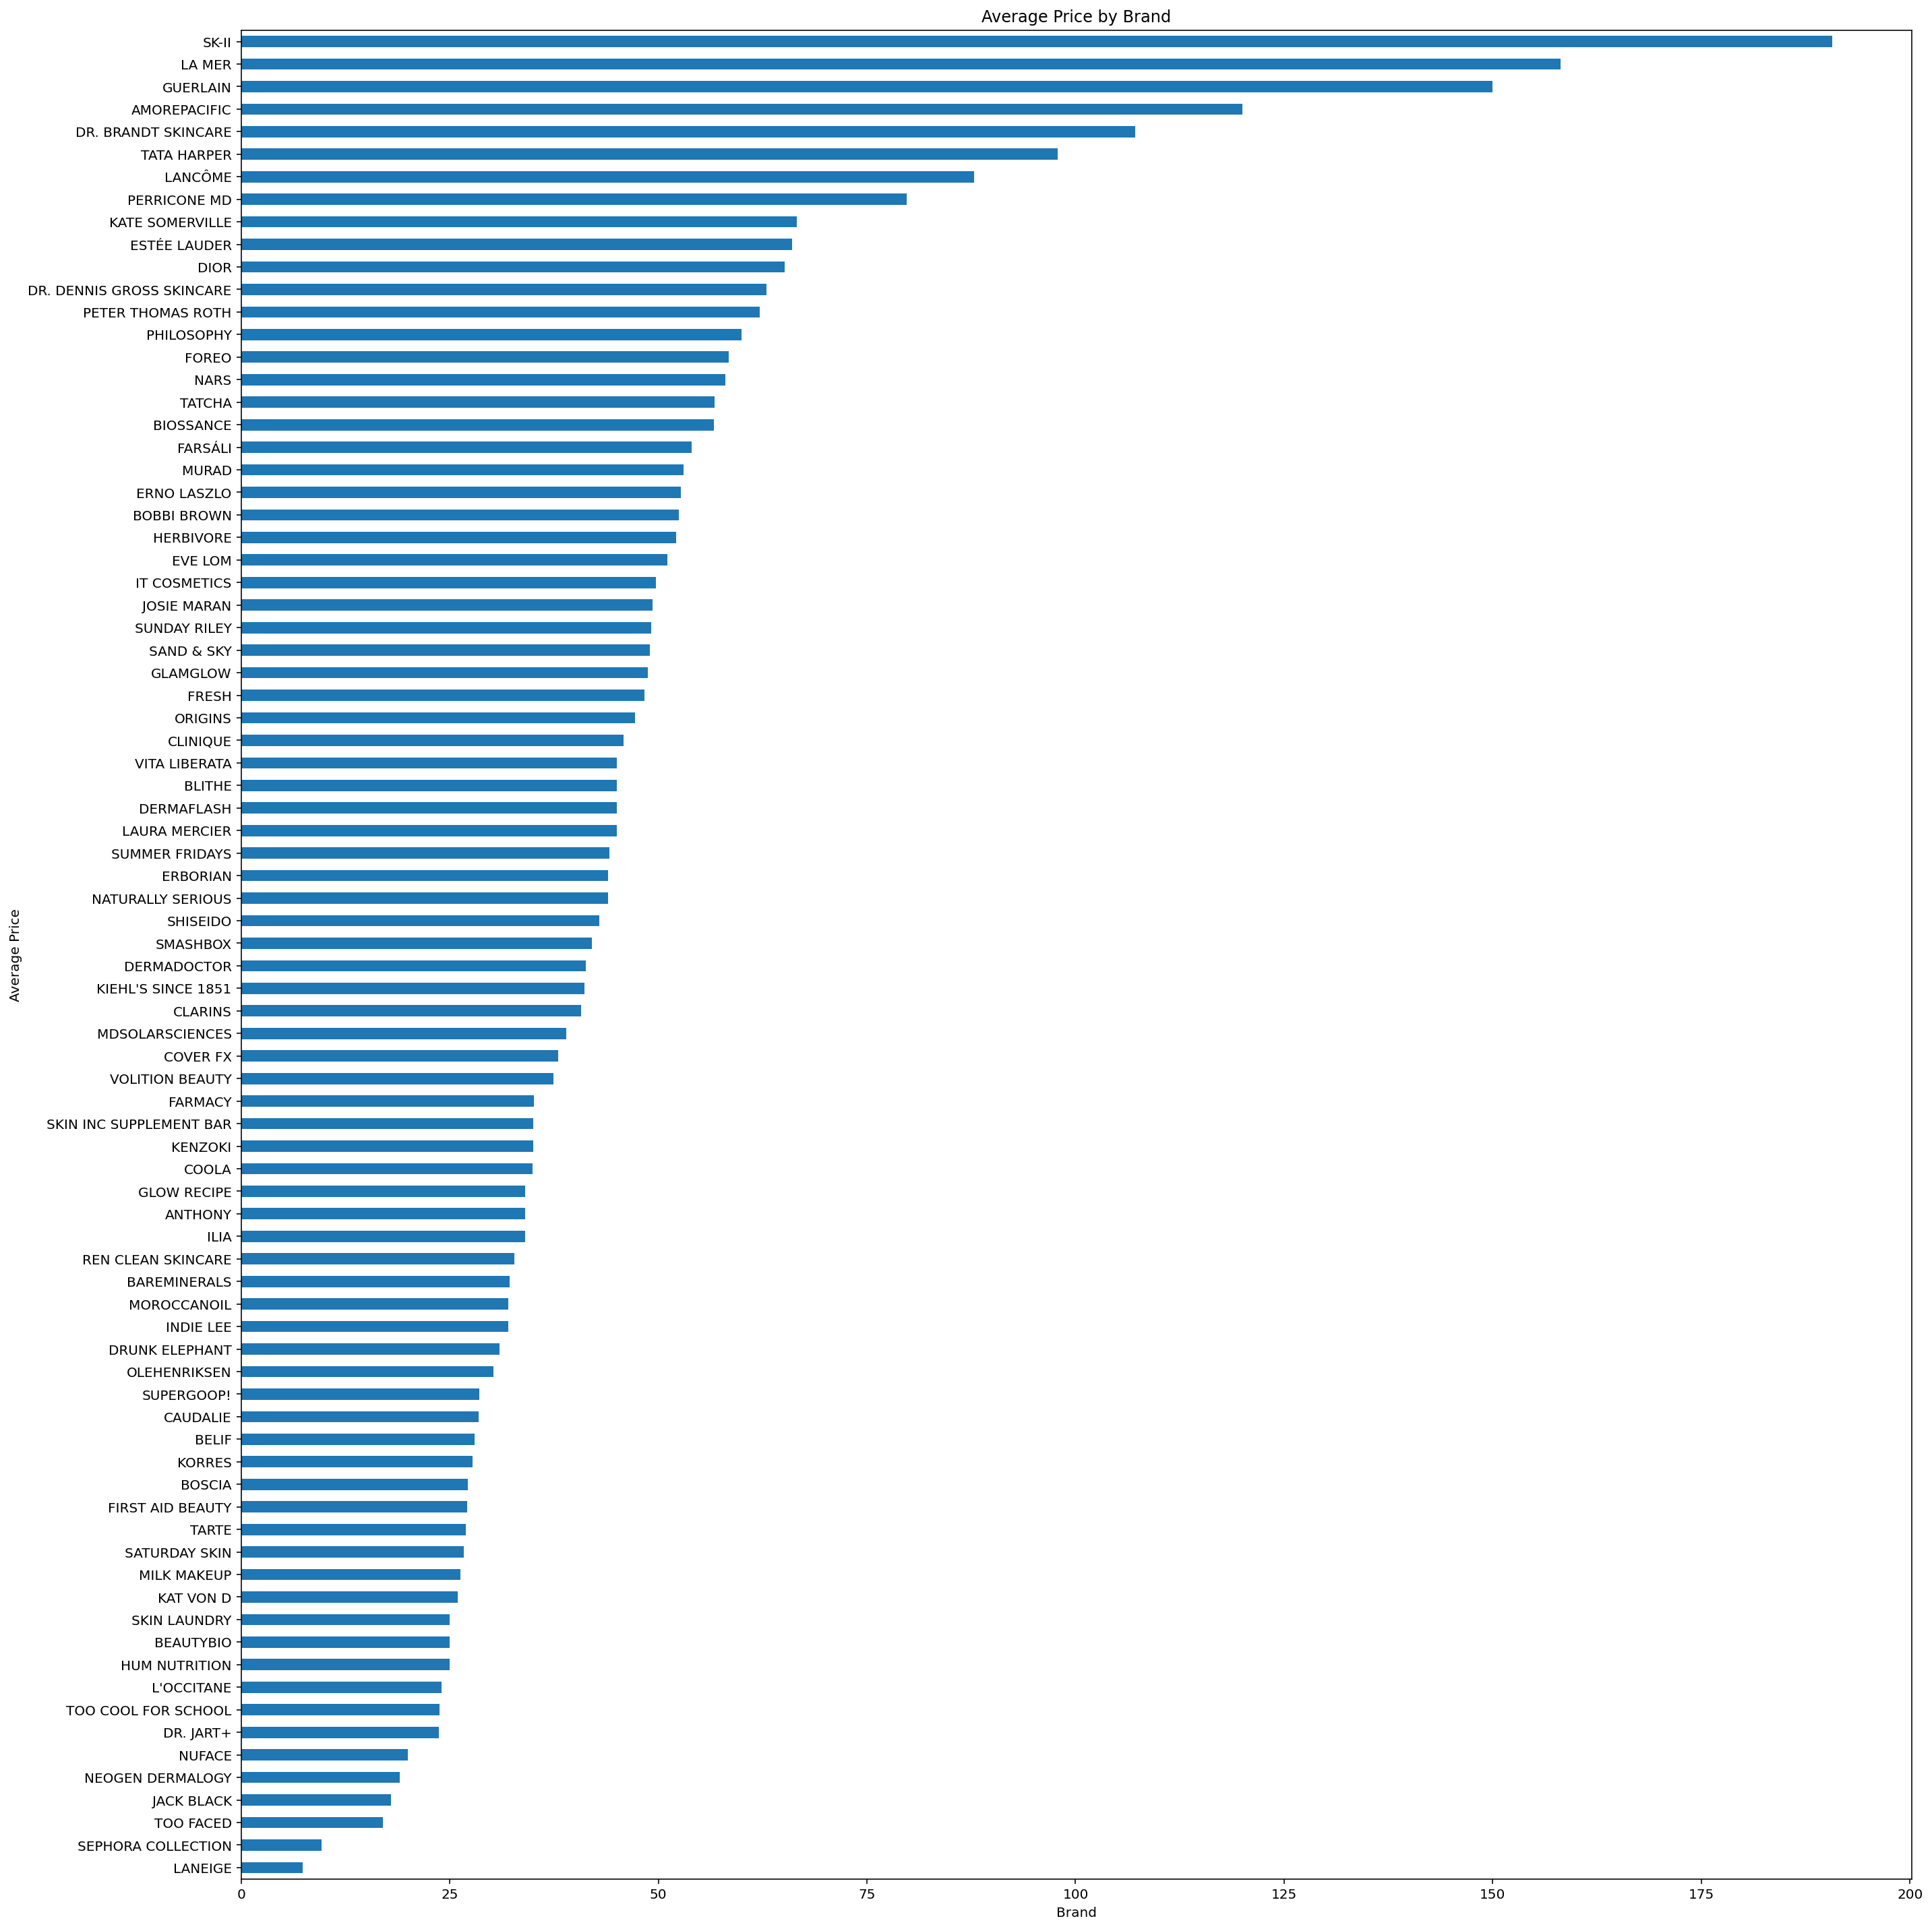

In [50]:
# plot the average price by brand
avg_price_by_brand = balanced_df.groupby('brand')['price'].mean().sort_values()

plt.figure(figsize=(20, 20))
avg_price_by_brand.plot(kind='barh')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

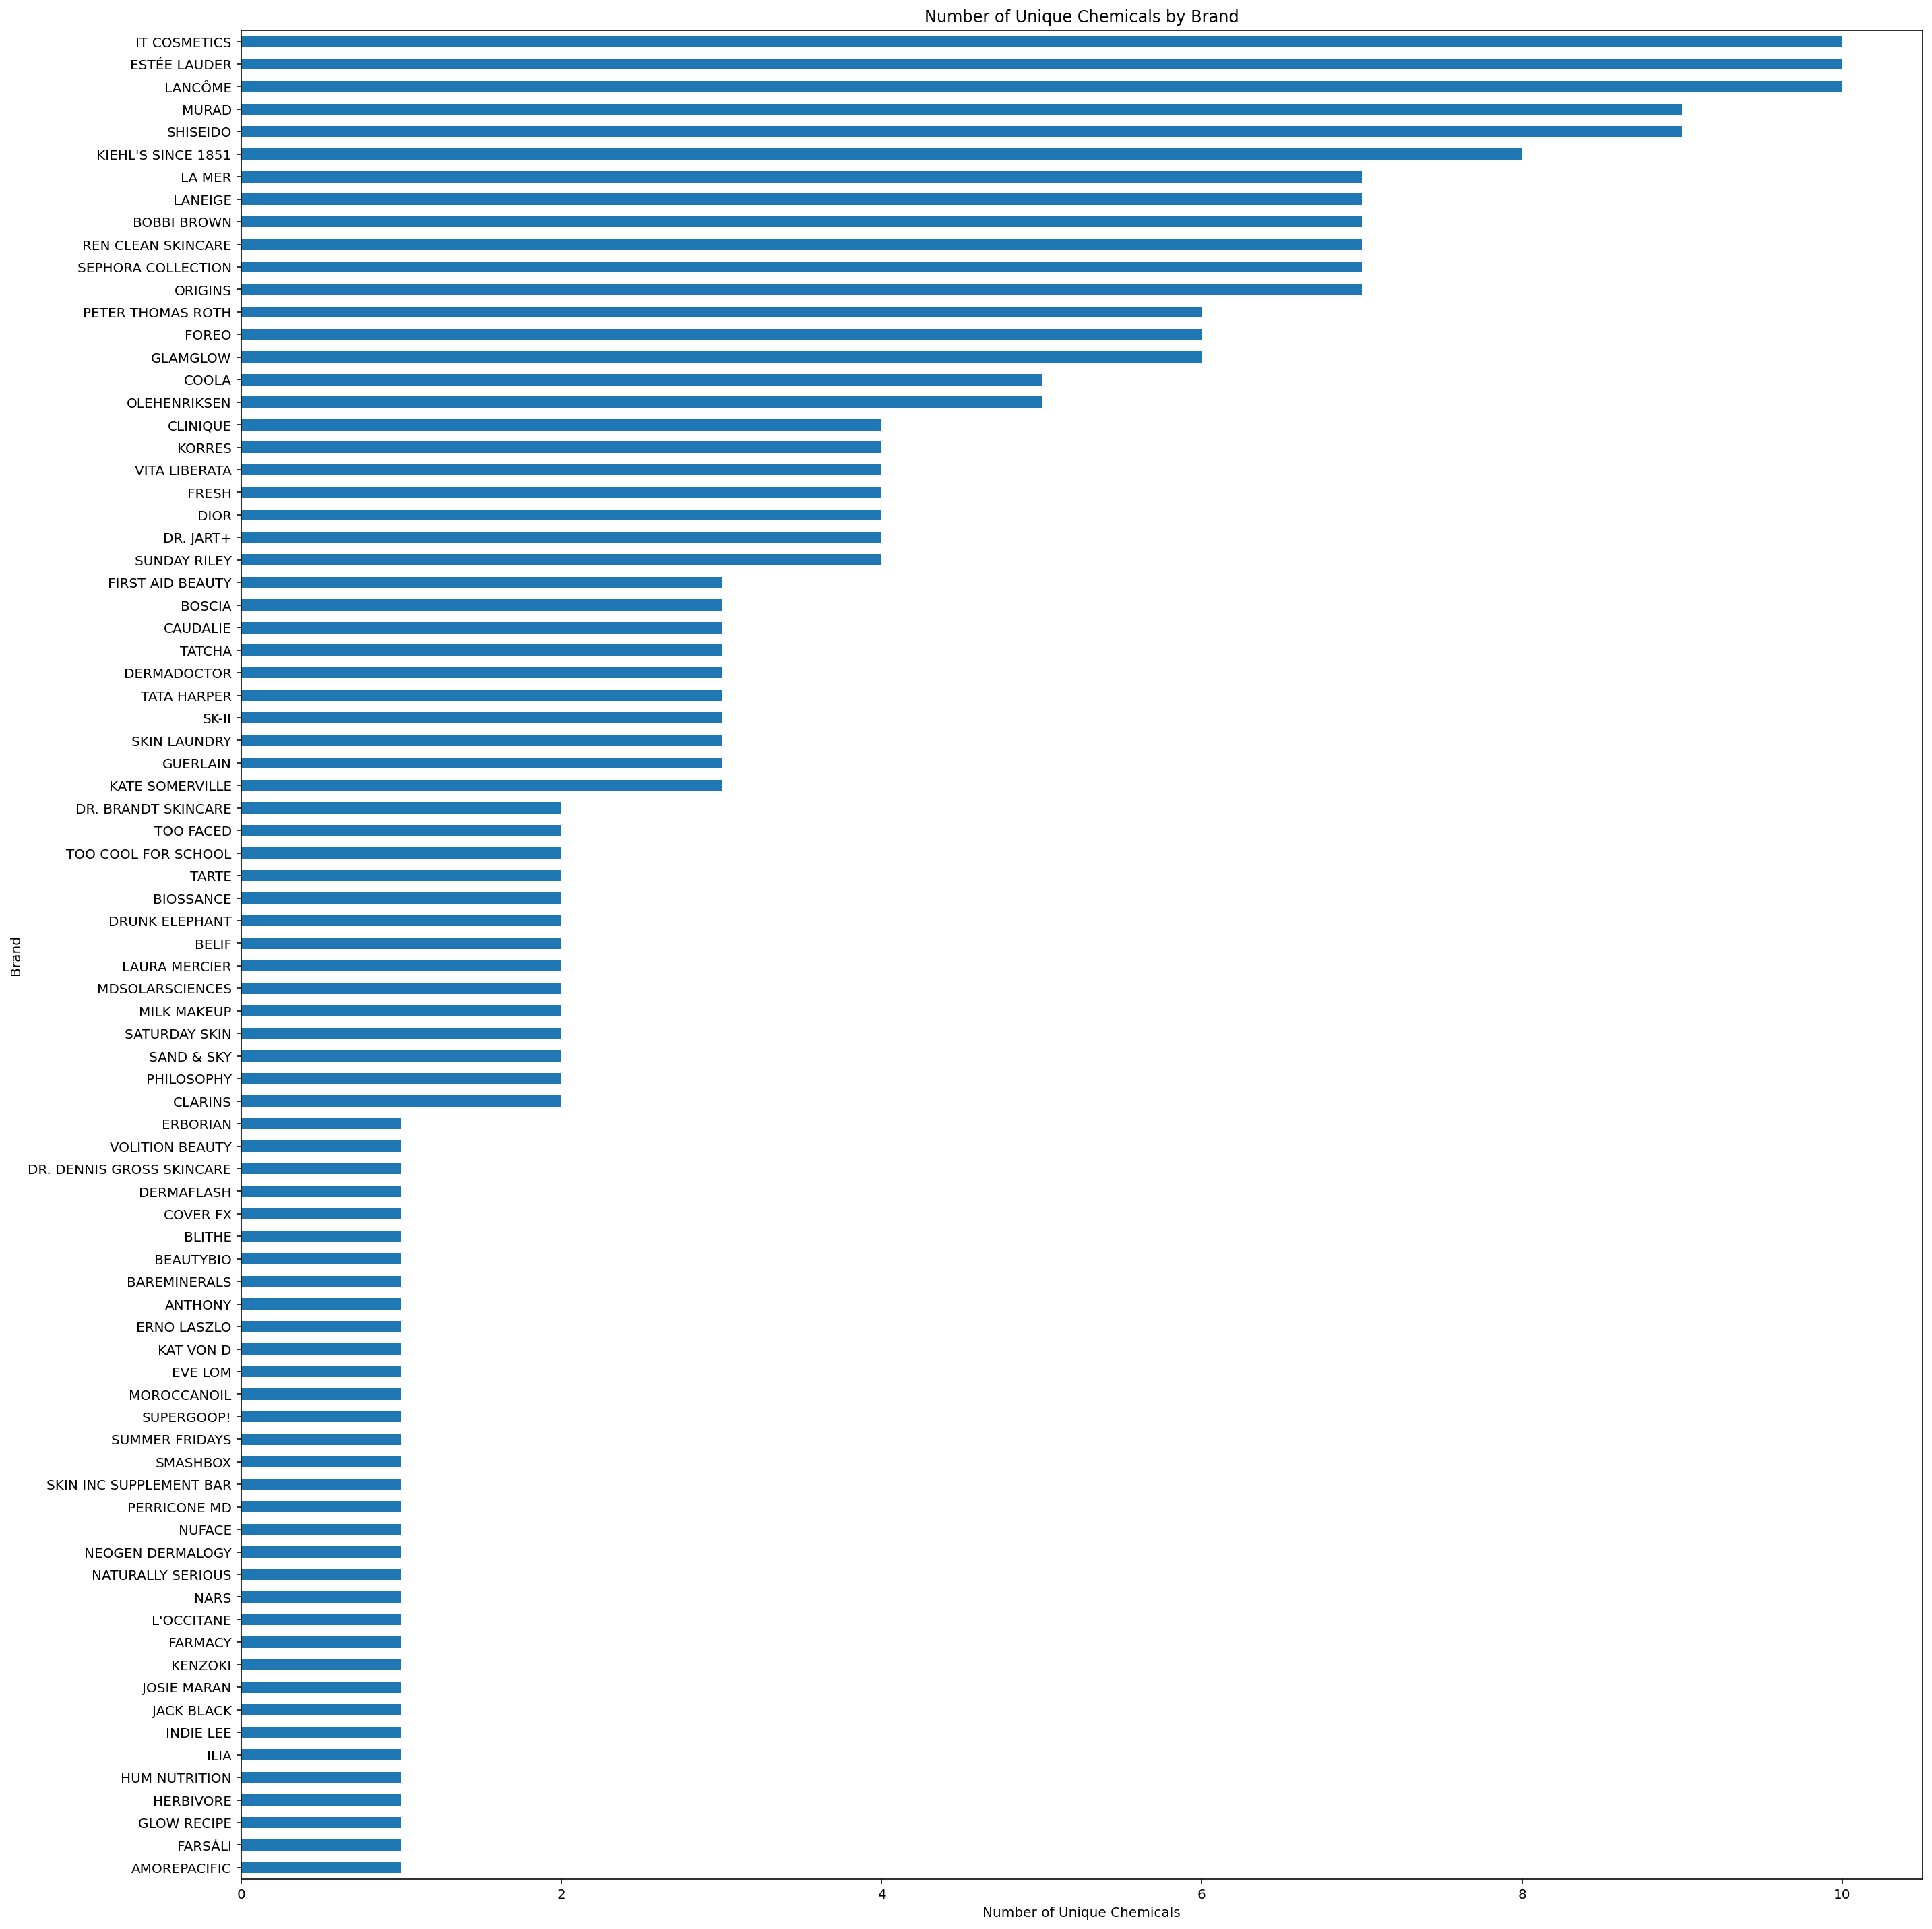

In [51]:
# number of unique chemicals per brand
chemicals_by_brand = balanced_df.groupby('brand')['ChemicalName'].nunique().sort_values()
plt.figure(figsize=(20, 20))
chemicals_by_brand.plot(kind='barh')
plt.xlabel('Number of Unique Chemicals')
plt.ylabel('Brand')
plt.title('Number of Unique Chemicals by Brand')
plt.tight_layout()
plt.show()

In [52]:
# pivot table to aggregate the binary values for each chemical and skin type combination
pivot_table = balanced_df.pivot_table(index='ChemicalName', 
                                values=['dry', 'normal', 'oily', 'sensitive'], 
                                aggfunc='sum')

<Figure size 1296x720 with 0 Axes>

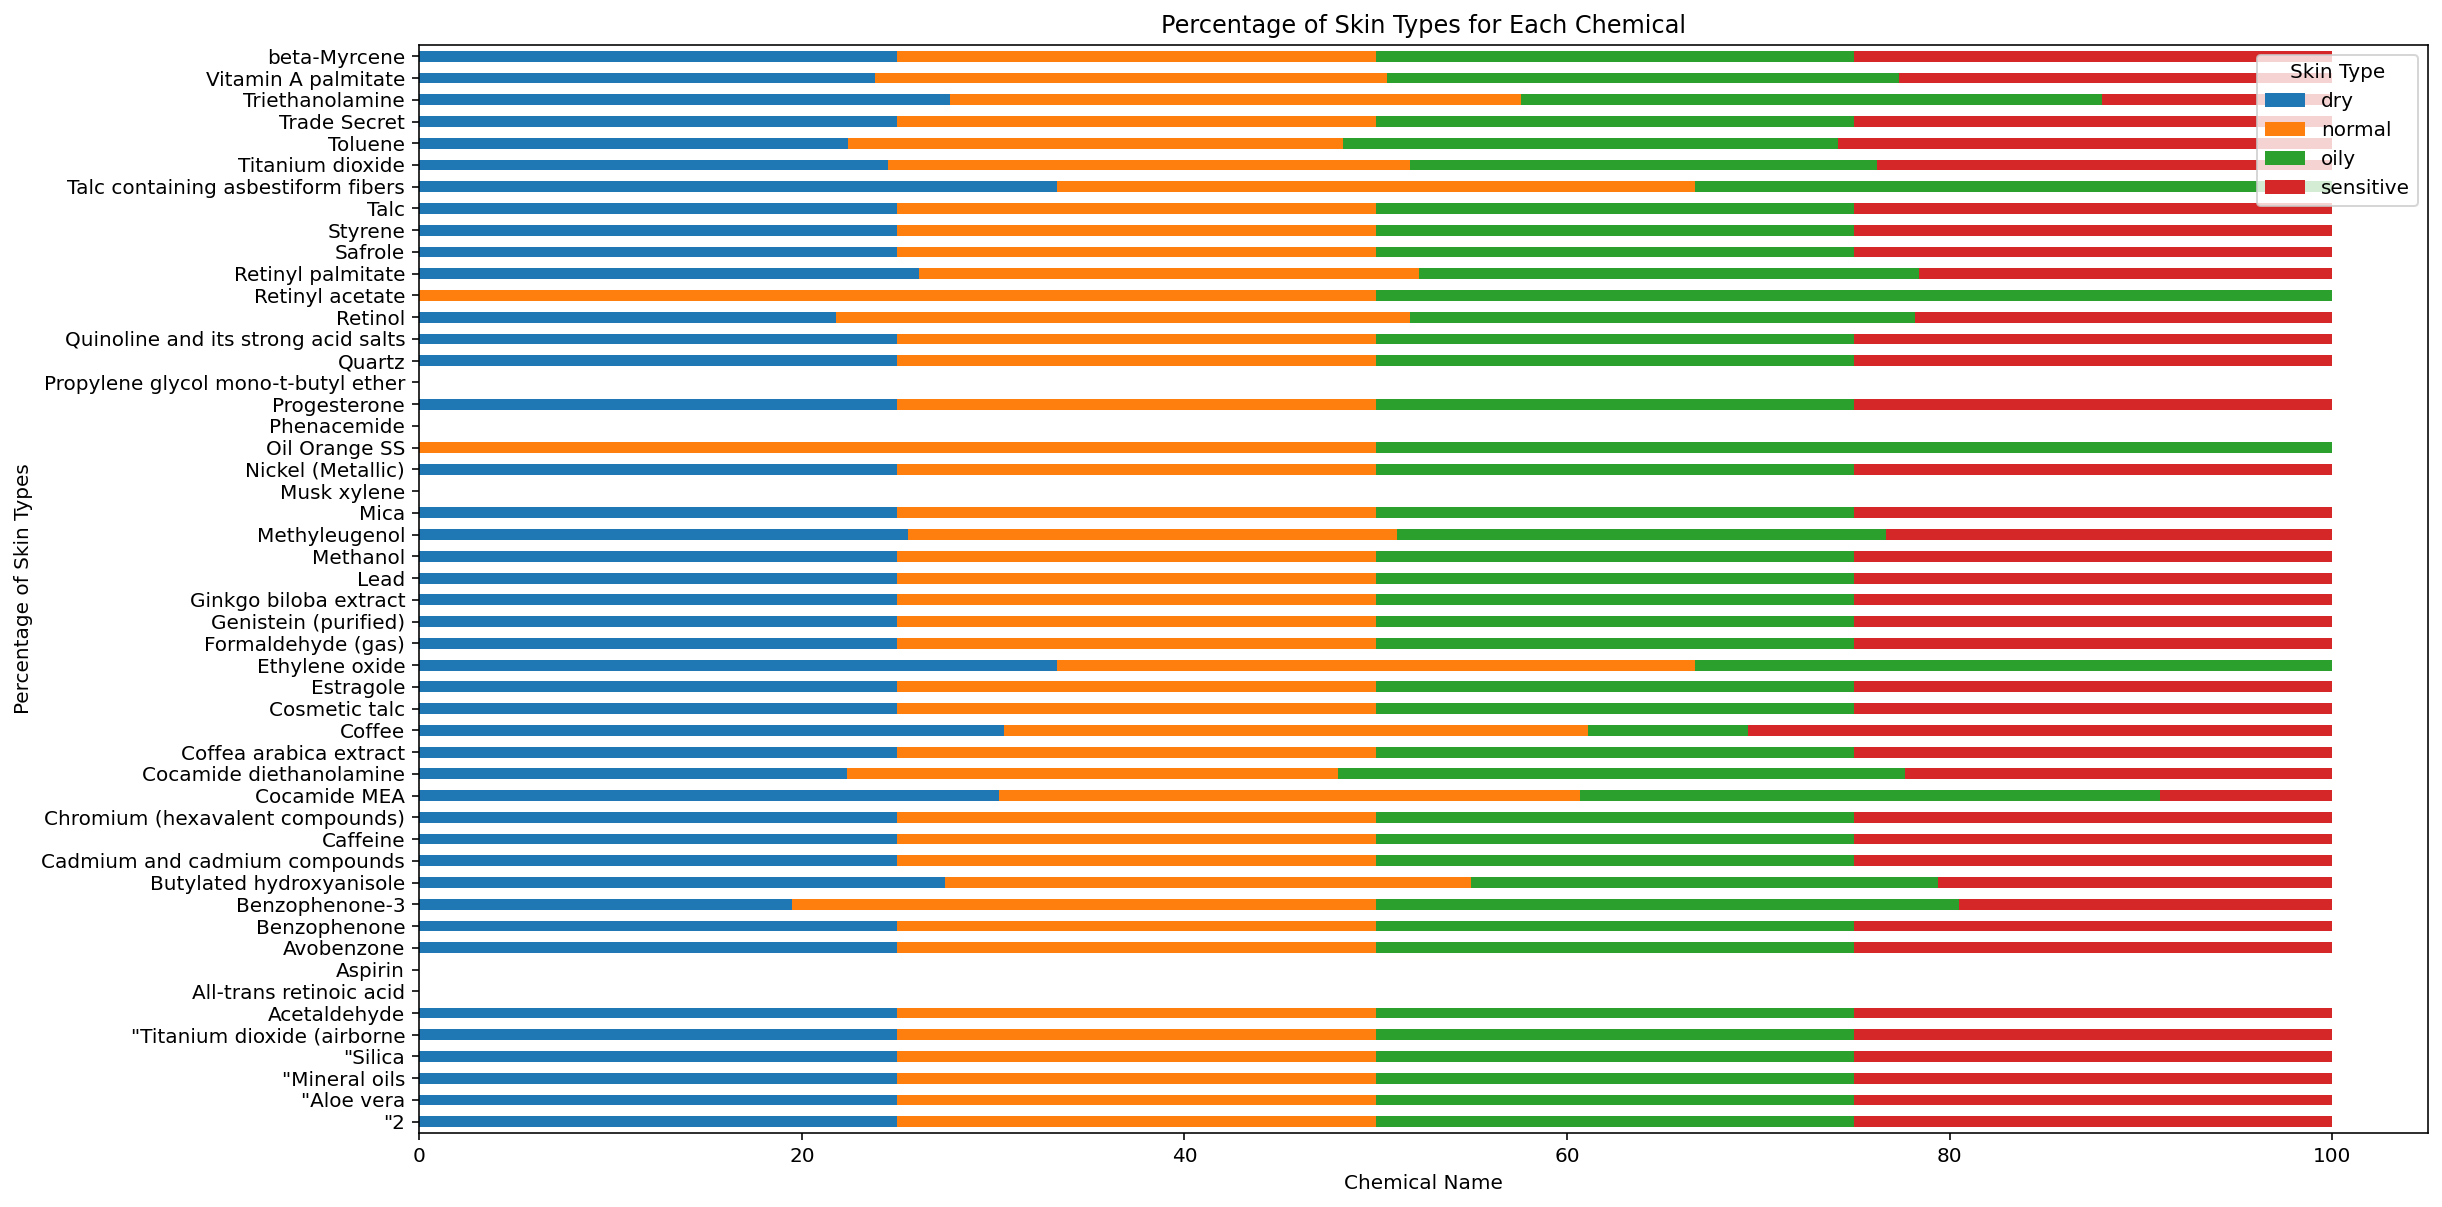

In [53]:
# calculate total number of chemicals per skin type
pivot_table['total'] = pivot_table.sum(axis=1)

# calculate percentage of each skin type for each chemical
for col in pivot_table.columns:
    pivot_table[col] = pivot_table[col] / pivot_table['total'] * 100
pivot_table.drop(columns='total', inplace=True)

# set figure size
plt.figure(figsize=(18, 10))

# plot % of skin types for each chemical 
pivot_table.plot(kind='barh', stacked=True, figsize=(18, 10))
plt.xlabel('Chemical Name')
plt.ylabel('Percentage of Skin Types')
plt.title('Percentage of Skin Types for Each Chemical')

plt.legend(title='Skin Type', loc='upper right')
plt.show();

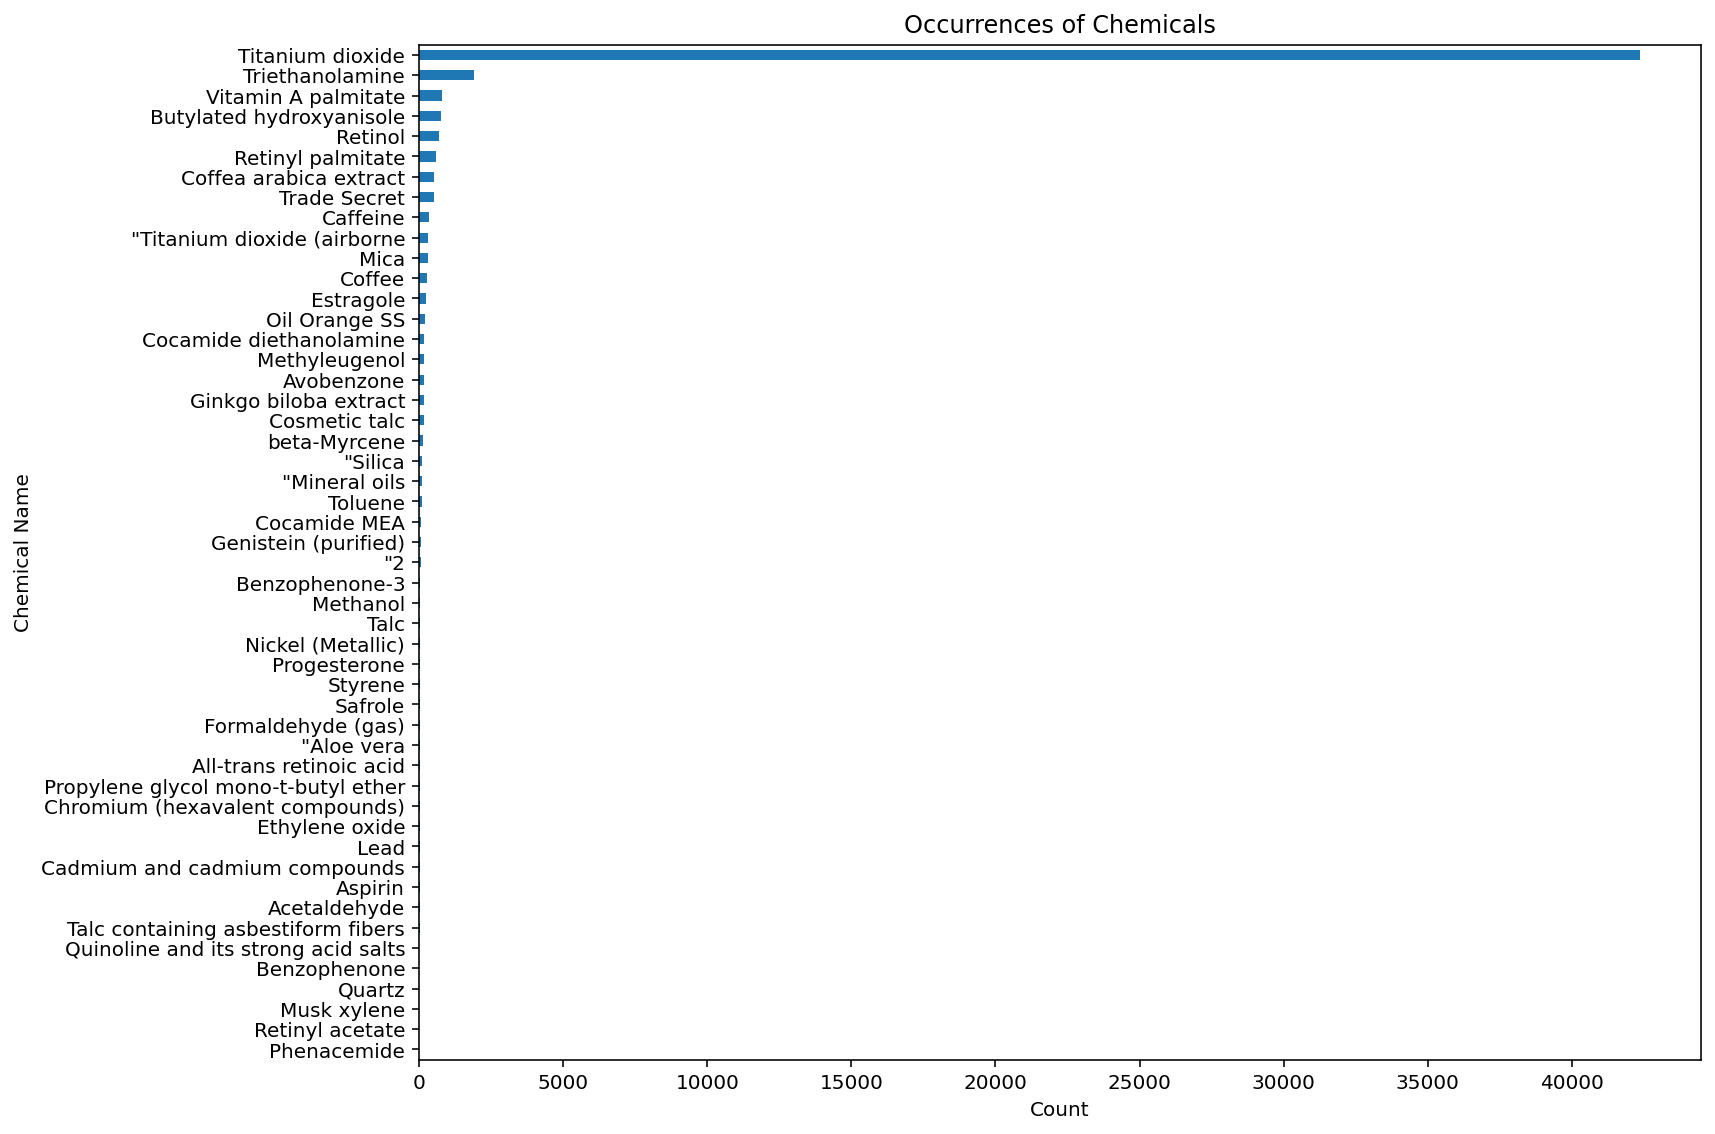

In [54]:
# count occurrences of each chemical
chemical_counts = balanced_df['ChemicalName'].value_counts()
chemical_counts_sorted = chemical_counts.sort_values(ascending=True)

# plot bar chart
plt.figure(figsize=(12, 8))
chemical_counts_sorted.plot(kind='barh')
plt.title('Occurrences of Chemicals')
plt.xlabel('Count')
plt.ylabel('Chemical Name')
plt.tight_layout()
plt.show()

In [55]:
# summary statistics of target column 'ordered'
balanced_df['ordered'].describe()

count    51784.000000
mean         0.112467
std          0.315943
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ordered, dtype: float64

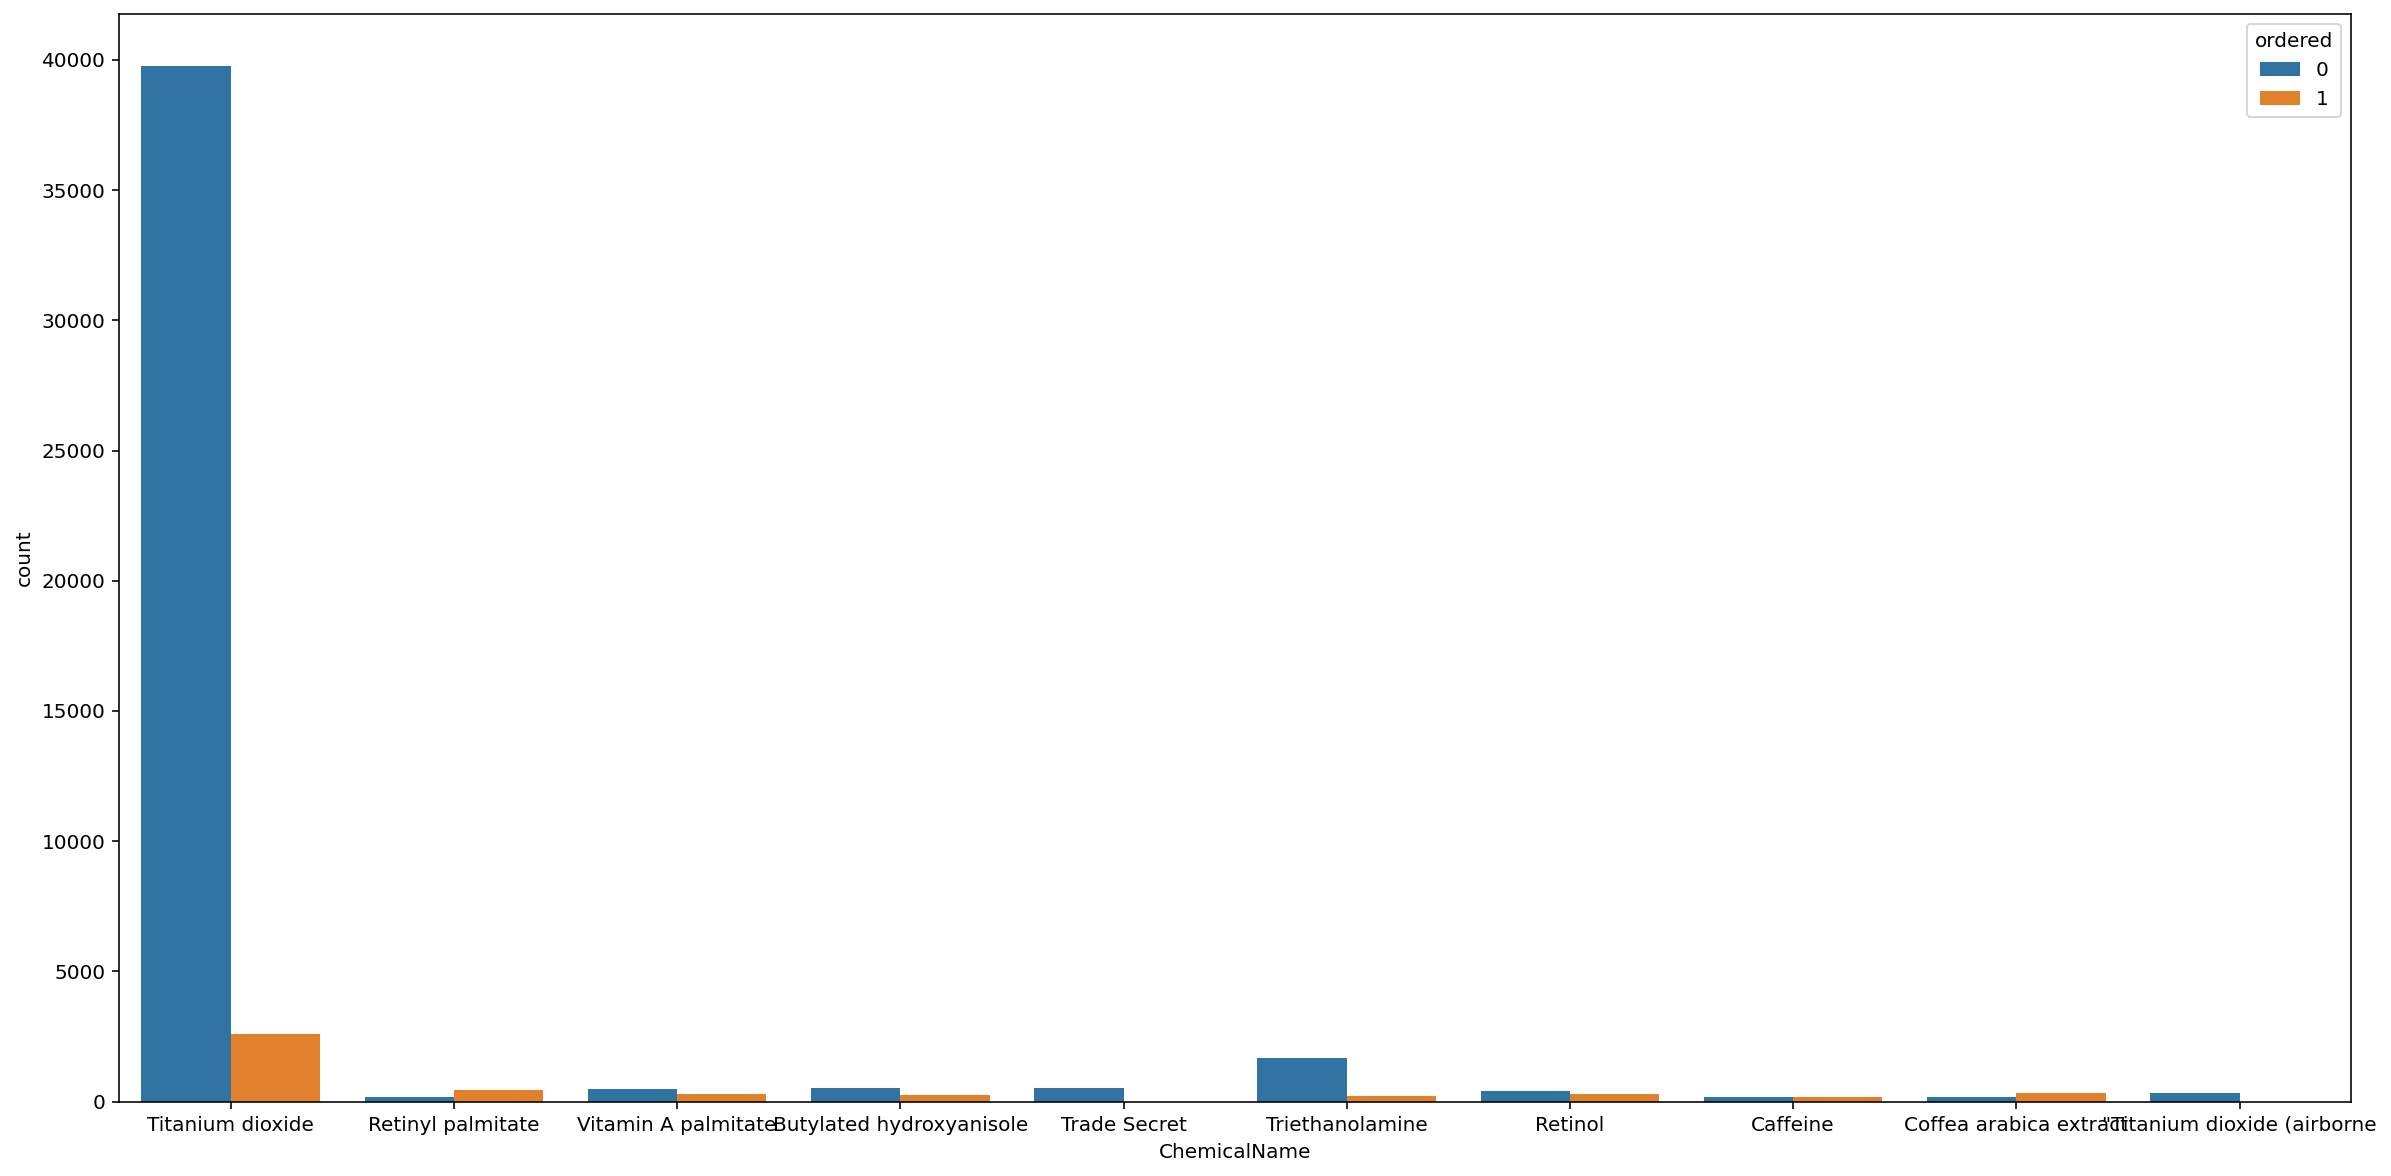

In [56]:
# create df for top chemicals + whether they were bought 
top_n_chemicals = balanced_df['ChemicalName'].value_counts().nlargest(10).index
top_n_df = balanced_df[balanced_df['ChemicalName'].isin(top_n_chemicals)]

# set figure
plt.figure(figsize=(20, 10))
sns.countplot(data=top_n_df, x="ChemicalName", hue="ordered")
plt.show()

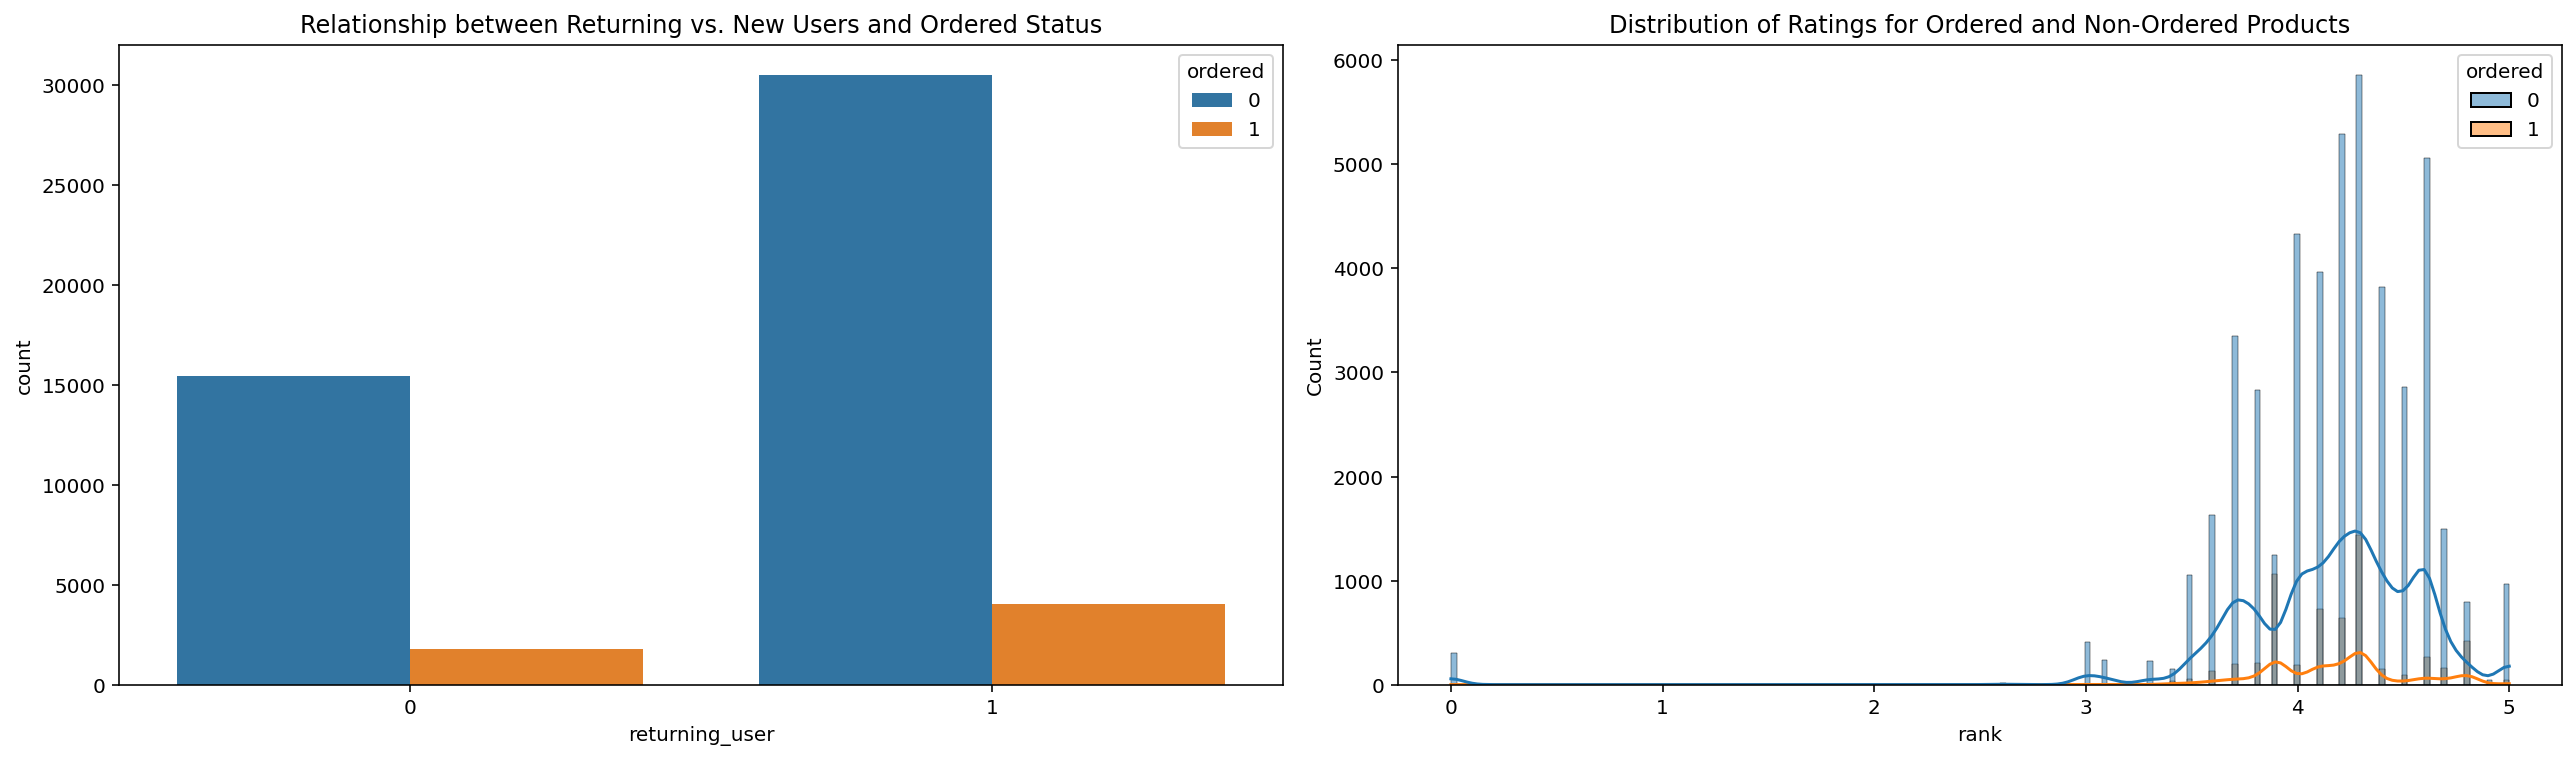

In [57]:
plt.figure(figsize=(18, 10))

# relationship between returning vs. new users and ordered status
plt.subplot(2, 2, 1)
sns.countplot(data=balanced_df, x='returning_user', hue='ordered')
plt.title('Relationship between Returning vs. New Users and Ordered Status')

# distribution of ratings for ordered and non-ordered products
plt.subplot(2, 2, 2)
sns.histplot(data=balanced_df, x='rank', hue='ordered', kde=True)
plt.title('Distribution of Ratings for Ordered and Non-Ordered Products')

plt.tight_layout()
plt.show()

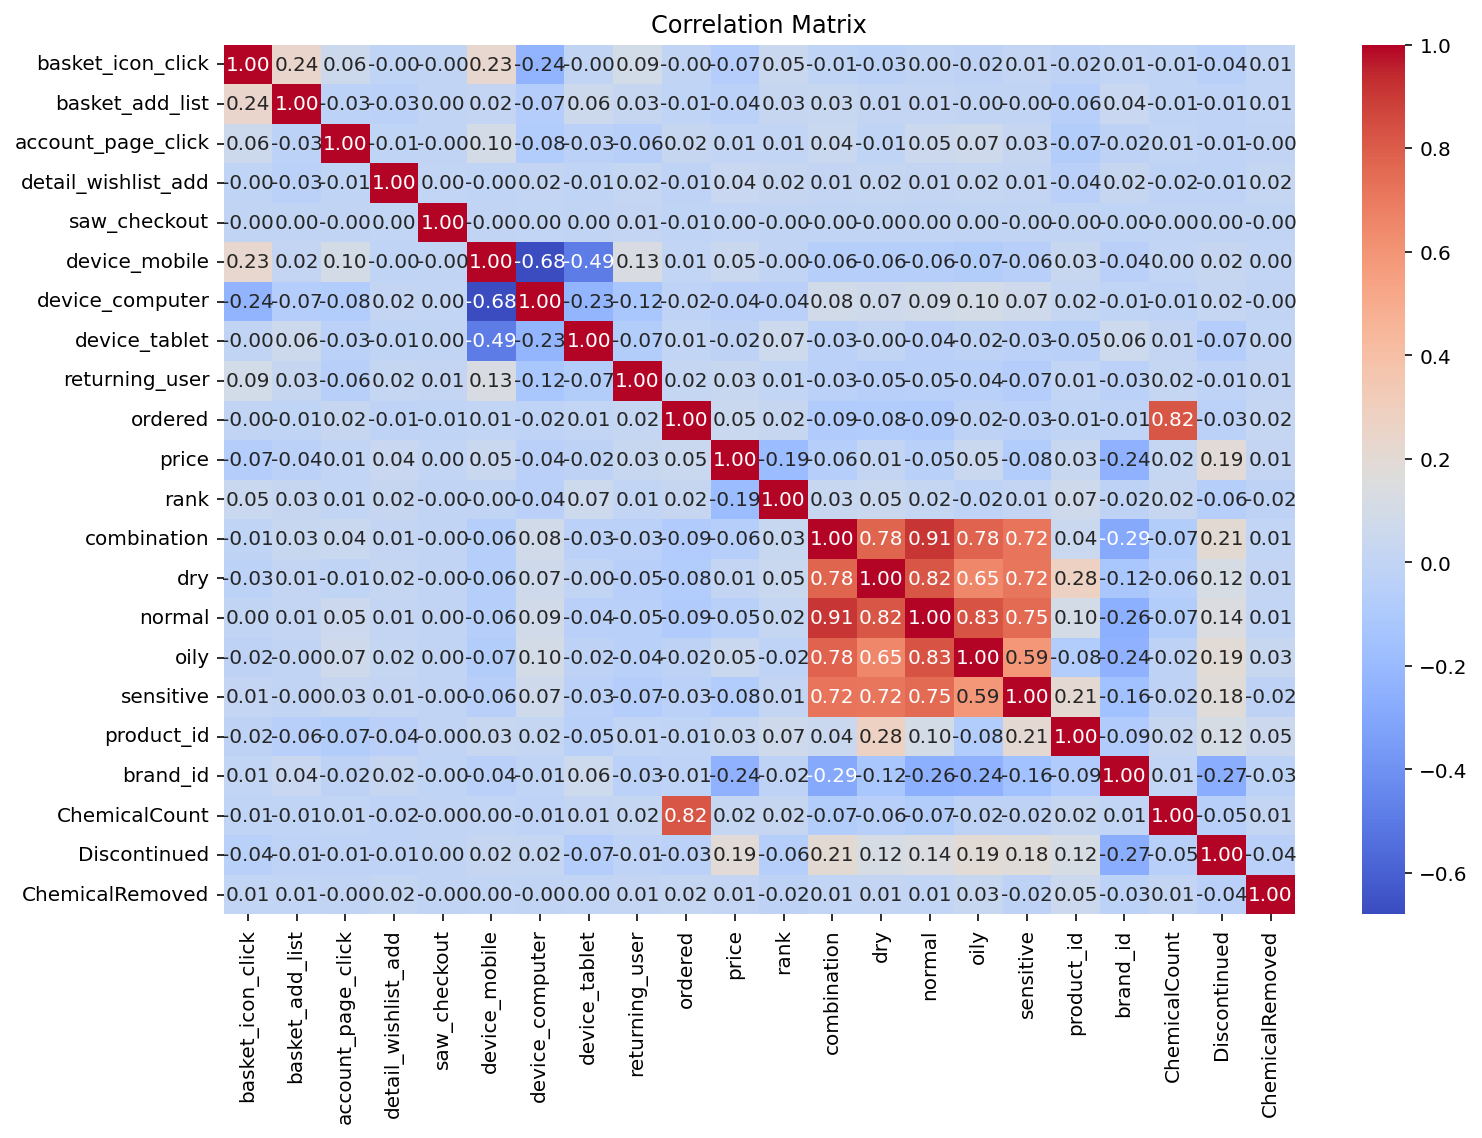

In [58]:
correlation_matrix = balanced_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Data Scrubbing 

#### Data Consistency

In [59]:
# Data consitency w/device columns 
inconsistent_records = balanced_df[(balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1]
print("Inconsistent records:", inconsistent_records)

Inconsistent records:                                     UserID  basket_icon_click  \
43781  7d03-8d37760d-7d03-b152-856b-663753                  1   
35742  1509-ac733b75-1509-438a-a711-244565                  1   
23786  9574-c637b7b1-9574-4d85-9141-213860                  1   
26501  92aa-b6562d84-92aa-b1av-b529-708647                  1   
46453  7a75-86a91e54-7a75-4157-9706-970044                  1   
...                                    ...                ...   
30026   9562-bb0b6307-9562-436a-a77b-43874                  1   
26472  92aa-b6562d84-92aa-b1av-b529-708647                  1   
30065   9562-bb0b6307-9562-436a-a77b-43874                  1   
8595    9347-62c8c097-9347-41e9-8612-97192                  1   
26516  92aa-b6562d84-92aa-b1av-b529-708647                  1   

       basket_add_list  account_page_click  detail_wishlist_add  saw_checkout  \
43781                0                   0                    0             0   
35742                1             

In [60]:
# drop inconcistent records - rows where the sum of device columns is greater than 1 (1049 rows were picked up to have suplicate values)
inconsistent_records_index = (balanced_df['device_mobile'] + balanced_df['device_computer'] + balanced_df['device_tablet']) > 1
balanced_df.drop(inconsistent_records_index.index[inconsistent_records_index], inplace=True)

In [61]:
balanced_df.shape #shape after duplicate values were dropped 

(50566, 30)

#### Data Type Conversion 

In [62]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50566 entries, 25076 to 41510
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               50566 non-null  object 
 1   basket_icon_click    50566 non-null  int64  
 2   basket_add_list      50566 non-null  int64  
 3   account_page_click   50566 non-null  int64  
 4   detail_wishlist_add  50566 non-null  int64  
 5   saw_checkout         50566 non-null  int64  
 6   device_mobile        50566 non-null  int64  
 7   device_computer      50566 non-null  int64  
 8   device_tablet        50566 non-null  int64  
 9   returning_user       50566 non-null  int64  
 10  ordered              50566 non-null  int64  
 11  label                50566 non-null  object 
 12  brand                50566 non-null  object 
 13  name                 50566 non-null  object 
 14  price                50566 non-null  float64
 15  rank                 50566 non-n

In [63]:
# convert Rank, Discontinued, and ChemicalRemoved, Dry to integer type
balanced_df['rank'] = balanced_df['rank'].astype(int)
balanced_df['Discontinued'] = balanced_df['Discontinued'].astype(int)
balanced_df['ChemicalRemoved'] = balanced_df['ChemicalRemoved'].astype(int)
balanced_df['dry'] = balanced_df['dry'].astype(int)

#### Outlier Detection 

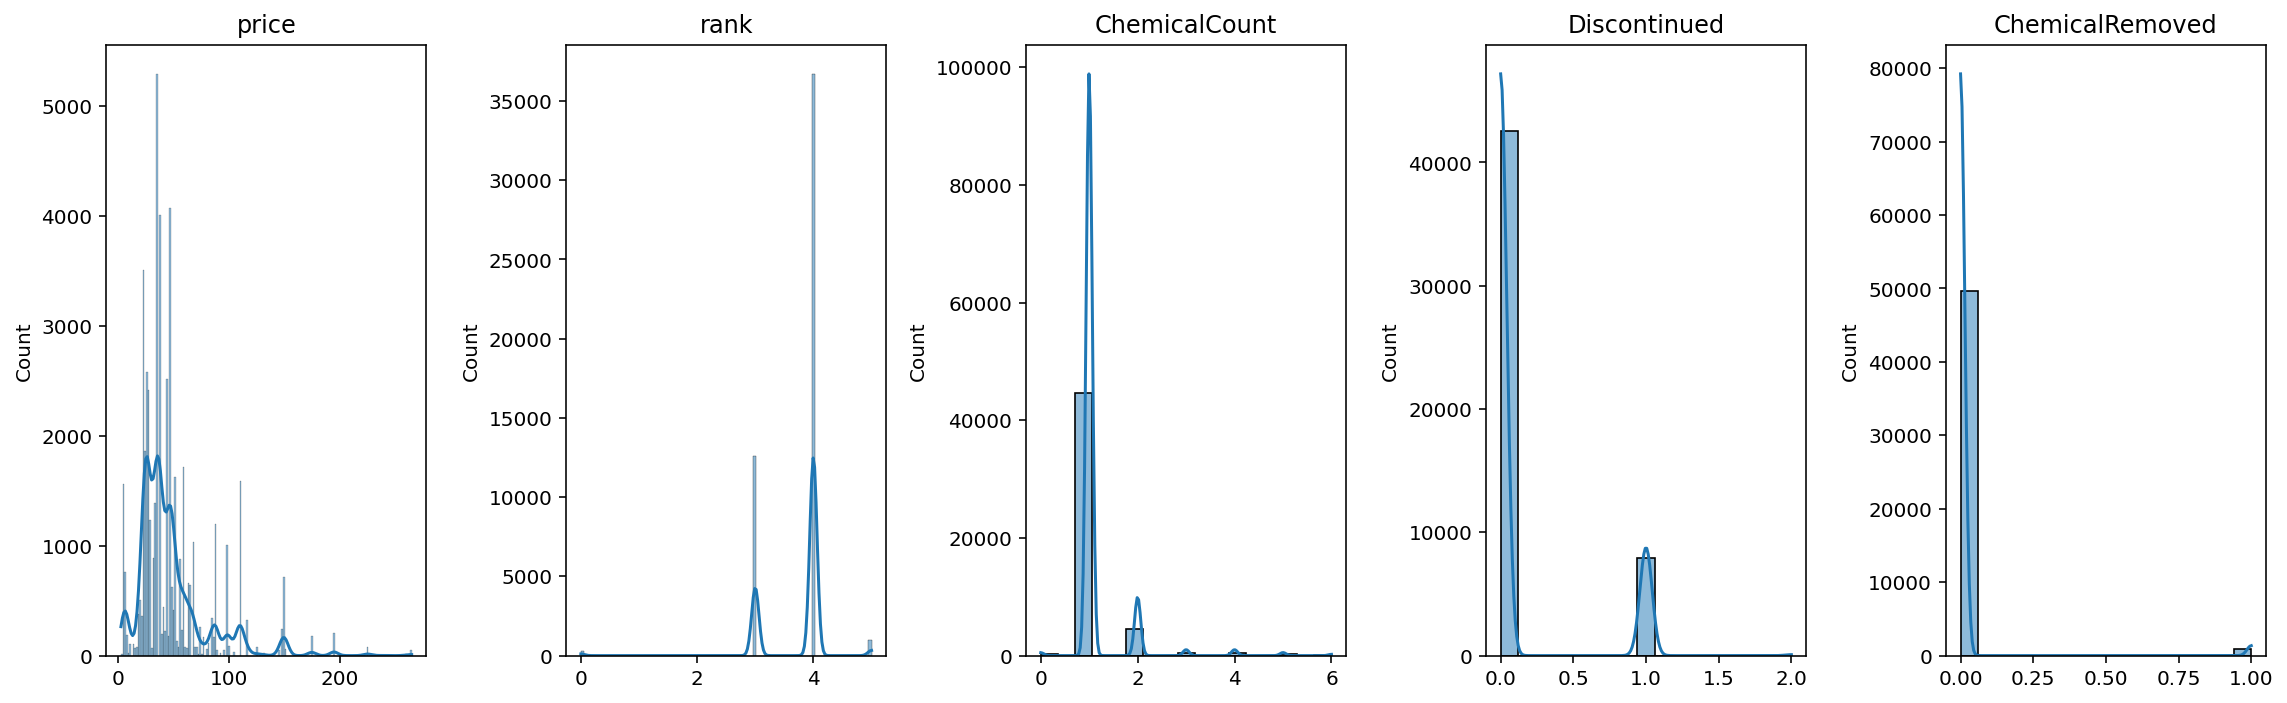

In [64]:
# visulaize potential outliers 
def visualize_distribution(balanced_df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 5))
    for i, col in enumerate(columns):
        sns.histplot(balanced_df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()

# define numerical columns for visualization
numerical_columns = ['price', 'rank', 'ChemicalCount', 'Discontinued', 'ChemicalRemoved']
visualize_distribution(balanced_df, numerical_columns)

In [65]:
 balanced_df[numerical_columns].describe() #outliers will remain in the df 

,price,rank,ChemicalCount,Discontinued,ChemicalRemoved
count,50566.000000,50566.000000,50566.000000,50566.000000,50566.000000
mean,48.013764,3.745244,1.156825,0.159198,0.016790
std,32.575761,0.549106,0.552627,0.369575,0.128485
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,3.000000,1.000000,0.000000,0.000000
50%,39.000000,4.000000,1.000000,0.000000,0.000000
75%,56.000000,4.000000,1.000000,0.000000,0.000000
max,265.000000,5.000000,6.000000,2.000000,1.000000


In [66]:
balanced_df['ChemicalCount'].value_counts() # inspect chemical count distribution 

1    44624
2     4487
3      453
4      452
5      231
0      223
6       96
Name: ChemicalCount, dtype: int64

#### Duplicate Values 

In [67]:
# check for duplicates
balanced_df.duplicated().sum() #original df is 52276 rows 

32753

In [68]:
duplicate_rows = balanced_df[balanced_df.duplicated()]
duplicate_rows.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
21129,8b17-c6093763-8b17-4d7d-98d1-631913,1,0,0,0,0,1,0,0,1,0,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1,1,0,1,108,886,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
21188,8b17-c6093763-8b17-4d7d-98d1-631913,1,0,0,0,0,1,0,0,1,0,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1,1,0,1,108,886,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
28065,72a2-38522124-72a2-411e-ab29-386584,1,0,0,0,0,1,0,0,0,0,Sun protect,FARMACY,Green Screen Daily Environmental Protector Bro...,36.0,4,Water- Ethyl Macadamiate- Cyclopentasiloxane- ...,1,1,1,1,1,35,1325,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
28118,72a2-38522124-72a2-411e-ab29-386584,1,0,0,0,0,1,0,0,0,0,Sun protect,FARMACY,Green Screen Daily Environmental Protector Bro...,36.0,4,Water- Ethyl Macadamiate- Cyclopentasiloxane- ...,1,1,1,1,1,35,1325,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
44996,71e5-12cb97aa-71e5-471e-9026-7567,1,0,0,0,0,1,0,0,1,0,Sun protect,FARMACY,Green Screen Daily Environmental Protector Bro...,36.0,4,Water- Ethyl Macadamiate- Cyclopentasiloxane- ...,1,1,1,1,1,35,1325,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0


In [69]:
duplicate_rows['UserID'].value_counts() #UserID has duplicate values, rows will be dropped

301d-bc415572-301d-4b76-a074-210697    254
604b-47236d94-604b-45cb-b76d-682826    250
42ca-61d63676-42ca-b1d2-b651-551718    250
7653-52386d78-7653-4b5b-8967-896234    249
7456-c6d1cd7c-7456-4571-8852-260084    249
                                      ... 
097a-ab7d3677-097a-4dcb-8375-799136      1
4d5a-583d23d7-4d5a-b13d-9b25-555193      1
6d33-19963b6d-6d33-4d78-8d75-35486       1
5b7b-76da1649-5b7b-4505-8138-305649      1
78b5-87d1b998-78b5-b1c0-8776-708321      1
Name: UserID, Length: 764, dtype: int64

In [70]:
# remove duplicate rows 
clean_df = balanced_df.drop_duplicates()
clean_df = clean_df.reset_index(drop=True)

In [71]:
# inspect df 
print('Number of Rows:', clean_df.shape[0])
print('Number of Columns:', clean_df.shape[1], '\n')

clean_df.info()

Number of Rows: 17813
Number of Columns: 30 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17813 entries, 0 to 17812
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               17813 non-null  object 
 1   basket_icon_click    17813 non-null  int64  
 2   basket_add_list      17813 non-null  int64  
 3   account_page_click   17813 non-null  int64  
 4   detail_wishlist_add  17813 non-null  int64  
 5   saw_checkout         17813 non-null  int64  
 6   device_mobile        17813 non-null  int64  
 7   device_computer      17813 non-null  int64  
 8   device_tablet        17813 non-null  int64  
 9   returning_user       17813 non-null  int64  
 10  ordered              17813 non-null  int64  
 11  label                17813 non-null  object 
 12  brand                17813 non-null  object 
 13  name                 17813 non-null  object 
 14  price                17813 non-null  flo

In [72]:
clean_df.head()

,UserID,basket_icon_click,basket_add_list,account_page_click,detail_wishlist_add,saw_checkout,device_mobile,device_computer,device_tablet,returning_user,ordered,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive,product_id,brand_id,PrimaryCategory,SubCategory,ChemicalName,ChemicalCount,Discontinued,ChemicalRemoved
0,0dd1-42a864a6-0dd1-4534-b177-648302,1,1,0,0,0,1,0,0,0,0,Face Mask,TOO COOL FOR SCHOOL,Egg Cream Mask Hydration,24.0,4,Water- Butylene Glycol- Glycerin- PEG-32- Cycl...,1,1,1,0,1,108,886,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
1,a095-3b32c56b-a095-474c-acc5-386955,0,0,0,0,0,1,0,0,1,0,Treatment,PETER THOMAS ROTH,Acne System,35.0,4,-4% Glycolic Acid Complex: Helps to exfoliate ...,1,1,1,1,1,87,704,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,0,0
2,2645-cc99db97-2645-4acc-8d13-707723,1,0,0,0,0,1,0,0,1,0,Moisturizer,SHISEIDO,Benefiance WrinkleResist24 Day Emulsion Broad ...,60.0,4,Water- Cyclomethicone- Dipropylene Glycol- Gly...,0,0,0,0,0,94,123,Skin Care Products,Nighttime Skin Care,Titanium dioxide,1,1,0
3,c495-69706b3a-c495-b108-8296-207192,1,1,0,0,0,1,0,0,1,0,Sun protect,SHISEIDO,Urban Environment Tinted UV Protector Broad Sp...,34.0,4,Visit the Shiseido boutique,0,0,0,0,0,94,1319,Sun-Related Products,Sunscreen (making a cosmetic claim),Titanium dioxide,1,1,0
4,73ac-5c323229-73ac-43b9-94b7-406724,1,0,0,0,0,1,0,0,0,0,Sun protect,SKIN LAUNDRY,Daily Moisturizer Broad Spectrum SPF 35,25.0,4,Acrylates/C10-30 Alkyl Acrylate Crosspolymer- ...,1,1,1,1,1,97,1420,Skin Care Products,Anti-Wrinkle/Anti-Aging Products (making a cos...,Titanium dioxide,1,0,0


### Feature Selection 

#### Chi-Square 

We will use chi-square to identify columns with high p-values and remove the redundant/irrelevant columns. 

In [73]:
# define target column to be analyzed for assocation 
target_column = 'ordered'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in clean_df.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=clean_df[column], columns=clean_df[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,UserID,4906.304494,0.000000e+00,1007
1,basket_icon_click,0.397318,5.284778e-01,1
2,basket_add_list,0.615917,4.325685e-01,1
3,account_page_click,0.879130,3.484401e-01,1
4,detail_wishlist_add,10.040129,1.531665e-03,1
5,saw_checkout,12.989750,3.132008e-04,1
6,device_mobile,0.518449,4.715042e-01,1
7,device_computer,3.747949,5.287234e-02,1
8,device_tablet,12.028603,5.239032e-04,1
9,returning_user,0.525698,4.684211e-01,1


In [74]:
# drop redundant columns such as userid, product_id, and brand_id and those identified with non-signifcant p-values
clean_df.drop(['UserID', 'name', 'brand_id', 'PrimaryCategory', 'SubCategory', 'ingredients', 
               'basket_icon_click', 'basket_add_list', 'ChemicalRemoved', 'ChemicalCount'], axis=1, inplace=True)

#### Variance Inflation Factor (VIF)

In [75]:
X_numeric = clean_df.select_dtypes(include=['float64', 'int64'])

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = X_numeric.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif)

               Variable        VIF
0    account_page_click   1.014420
1   detail_wishlist_add   1.011013
2          saw_checkout   1.001394
3         device_mobile  38.682612
4       device_computer  14.952790
5         device_tablet   9.138608
6        returning_user   1.034228
7               ordered   1.038327
8                 price   1.070505
9                  rank   1.077503
10          combination   5.608845
11                  dry   6.047080
12               normal  12.123758
13                 oily   5.576435
14            sensitive   3.124944
15           product_id   1.116359
16         Discontinued   1.100390


It's recommended to drop variables with high VIF values (>10) as they indicate significant multicollinearity. The following columns will be dropped: device_mobile, device_computer, device_tablet. 

In [76]:
# drop specified columns
clean_df.drop(['device_mobile', 'device_computer', 'device_tablet'], axis=1, inplace=True)

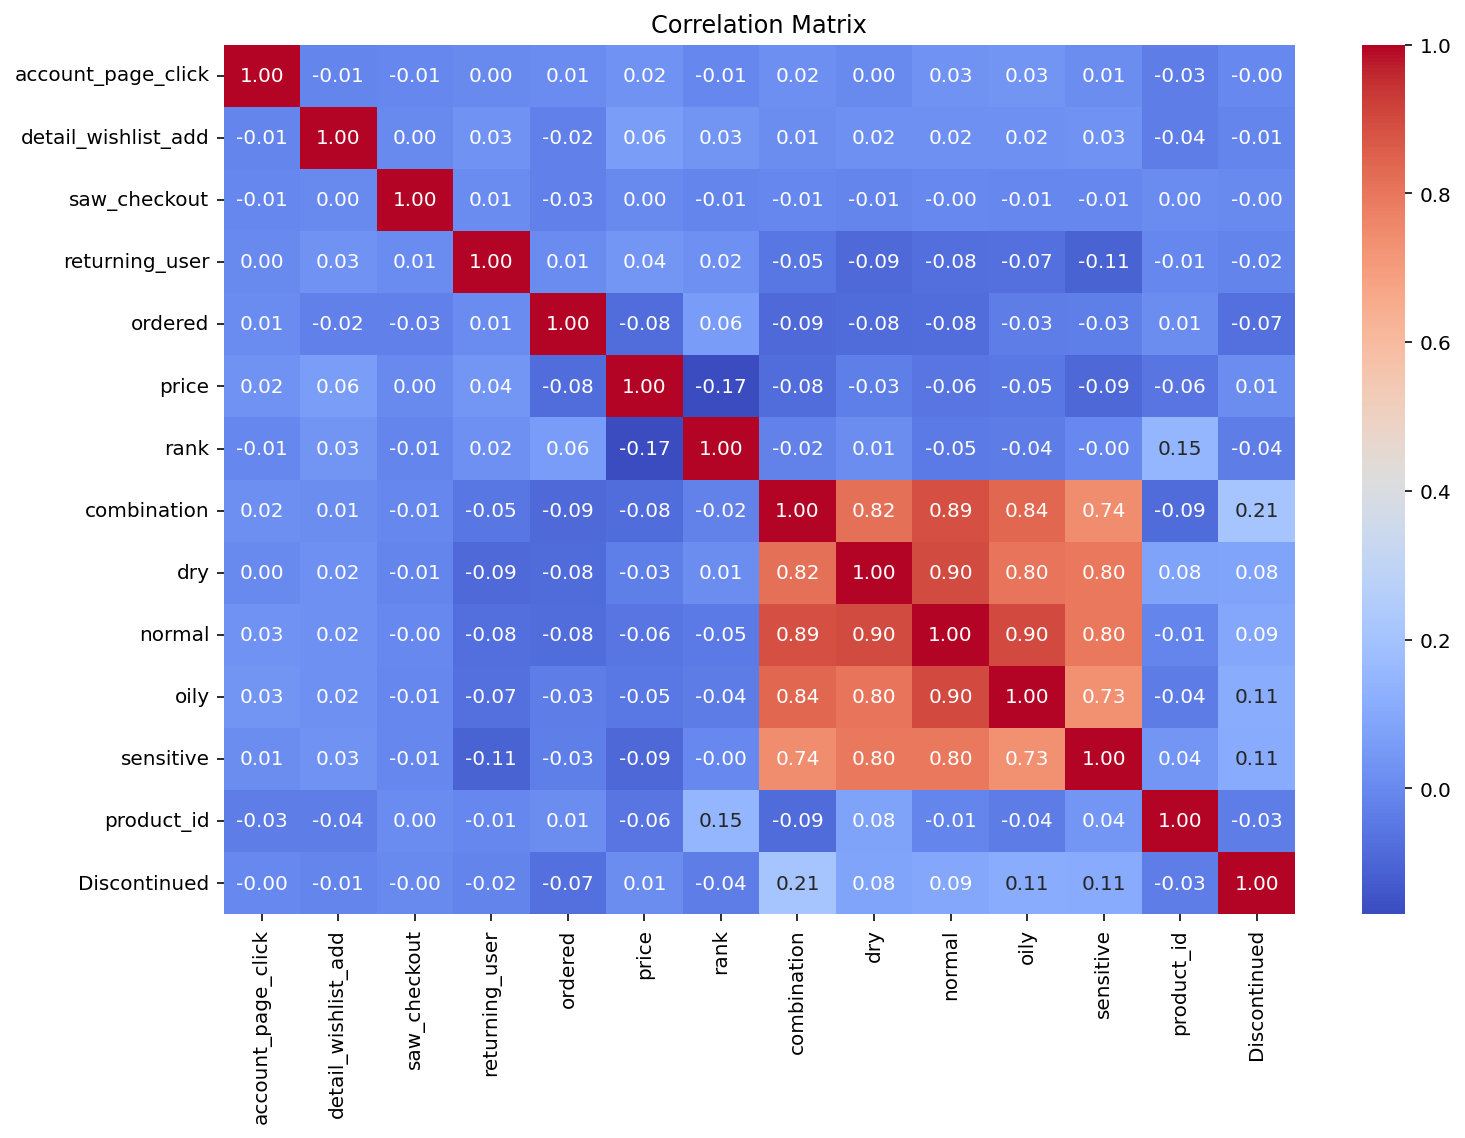

In [77]:
# create correlation matrix with reduced df 
correlation_matrix = clean_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [78]:
# correlation bewteen ordered and other variables 
ordered_correlation = correlation_matrix['ordered']
ordered_correlation

account_page_click     0.007505
detail_wishlist_add   -0.024625
saw_checkout          -0.027143
returning_user         0.005582
ordered                1.000000
price                 -0.081716
rank                   0.058281
combination           -0.088354
dry                   -0.084884
normal                -0.082344
oily                  -0.034604
sensitive             -0.028890
product_id             0.011051
Discontinued          -0.071847
Name: ordered, dtype: float64

#### Feature Transformation

In [79]:
# one hot encode categorical variables
cat_col = ["label", "brand", "ChemicalName", "rank"]
clean_df['ChemicalName'] = clean_df['ChemicalName'].str.replace('"', '')
encoded_df = pd.get_dummies(clean_df, columns=cat_col)

In [80]:
encoded_df.head()

,account_page_click,detail_wishlist_add,saw_checkout,returning_user,ordered,price,combination,dry,normal,oily,sensitive,product_id,Discontinued,label_Cleanser,label_Eye cream,label_Face Mask,label_Moisturizer,label_Sun protect,label_Treatment,brand_AMOREPACIFIC,brand_ANTHONY,brand_BAREMINERALS,brand_BEAUTYBIO,brand_BELIF,brand_BIOSSANCE,brand_BLITHE,brand_BOBBI BROWN,brand_BOSCIA,brand_CAUDALIE,brand_CLARINS,brand_CLINIQUE,brand_COOLA,brand_COVER FX,brand_DERMADOCTOR,brand_DERMAFLASH,brand_DIOR,brand_DR. BRANDT SKINCARE,brand_DR. DENNIS GROSS SKINCARE,brand_DR. JART+,brand_DRUNK ELEPHANT,brand_ERBORIAN,brand_ERNO LASZLO,brand_ESTÉE LAUDER,brand_EVE LOM,brand_FARMACY,brand_FARSÁLI,brand_FIRST AID BEAUTY,brand_FOREO,brand_FRESH,brand_GLAMGLOW,brand_GLOW RECIPE,brand_GUERLAIN,brand_HERBIVORE,brand_HUM NUTRITION,brand_ILIA,brand_INDIE LEE,brand_IT COSMETICS,brand_JACK BLACK,brand_JOSIE MARAN,brand_KAT VON D,brand_KATE SOMERVILLE,brand_KENZOKI,brand_KIEHL'S SINCE 1851,brand_KORRES,brand_L'OCCITANE,brand_LA MER,brand_LANCÔME,brand_LANEIGE,brand_LAURA MERCIER,brand_MDSOLARSCIENCES,brand_MILK MAKEUP,brand_MOROCCANOIL,brand_MURAD,brand_NARS,brand_NATURALLY SERIOUS,brand_NEOGEN DERMALOGY,brand_NUFACE,brand_OLEHENRIKSEN,brand_ORIGINS,brand_PERRICONE MD,brand_PETER THOMAS ROTH,brand_PHILOSOPHY,brand_REN CLEAN SKINCARE,brand_SAND & SKY,brand_SATURDAY SKIN,brand_SEPHORA COLLECTION,brand_SHISEIDO,brand_SK-II,brand_SKIN INC SUPPLEMENT BAR,brand_SKIN LAUNDRY,brand_SMASHBOX,brand_SUMMER FRIDAYS,brand_SUNDAY RILEY,brand_SUPERGOOP!,brand_TARTE,brand_TATA HARPER,brand_TATCHA,brand_TOO COOL FOR SCHOOL,brand_TOO FACED,brand_VITA LIBERATA,brand_VOLITION BEAUTY,ChemicalName_2,ChemicalName_Acetaldehyde,ChemicalName_All-trans retinoic acid,ChemicalName_Aloe vera,ChemicalName_Aspirin,ChemicalName_Avobenzone,ChemicalName_Benzophenone,ChemicalName_Benzophenone-3,ChemicalName_Butylated hydroxyanisole,ChemicalName_Cadmium and cadmium compounds,ChemicalName_Caffeine,ChemicalName_Chromium (hexavalent compounds),ChemicalName_Cocamide MEA,ChemicalName_Cocamide diethanolamine,ChemicalName_Coffea arabica extract,ChemicalName_Coffee,ChemicalName_Cosmetic talc,ChemicalName_Estragole,ChemicalName_Ethylene oxide,ChemicalName_Formaldehyde (gas),ChemicalName_Genistein (purified),ChemicalName_Ginkgo biloba extract,ChemicalName_Lead,ChemicalName_Methanol,ChemicalName_Methyleugenol,ChemicalName_Mica,ChemicalName_Mineral oils,ChemicalName_Musk xylene,ChemicalName_Nickel (Metallic),ChemicalName_Oil Orange SS,ChemicalName_Phenacemide,ChemicalName_Progesterone,ChemicalName_Propylene glycol mono-t-butyl ether,ChemicalName_Quartz,ChemicalName_Quinoline and its strong acid salts,ChemicalName_Retinol,ChemicalName_Retinyl acetate,ChemicalName_Retinyl palmitate,ChemicalName_Safrole,ChemicalName_Silica,ChemicalName_Styrene,ChemicalName_Talc,ChemicalName_Talc containing asbestiform fibers,ChemicalName_Titanium dioxide,ChemicalName_Titanium dioxide (airborne,ChemicalName_Toluene,ChemicalName_Trade Secret,ChemicalName_Triethanolamine,ChemicalName_Vitamin A palmitate,ChemicalName_beta-Myrcene,rank_0,rank_2,rank_3,rank_4,rank_5
0,0,0,0,0,0,24.0,1,1,1,0,1,108,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,35.0,1,1,1,1,1,87,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,60.0,0,0,0,0,0,94,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [81]:
encoded_df.shape

(17813, 156)

#### PCA

In [82]:
# create a copy of encoded_df before applying PCA 
pca_df = encoded_df.copy()

In [83]:
# standardize the data
scaler = StandardScaler()
# fit and transform data using scaler 
df_standardized = scaler.fit_transform(pca_df)

In [84]:
# apply PCA
pca = PCA()
pca.fit(df_standardized)

# calculate the cumulative explained variance ratio
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

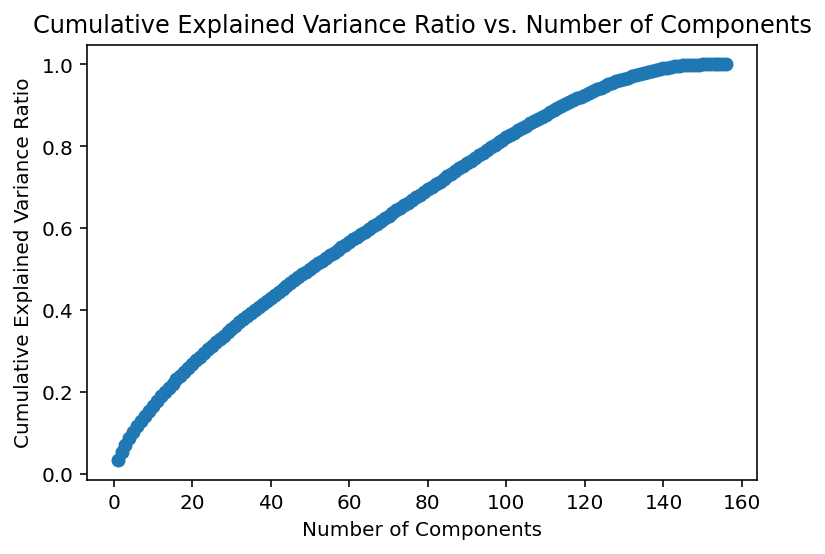

In [85]:
# plot cumulative explained variance ratio
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

In [86]:
# find the number of components that fall within 80% to 90% cumulative explained variance
target_variance_range = (0.80, 0.90)

# use NumPy to find the index of the first component within the specified variance range
target_components = np.where((explained_variance_ratio_cumulative >= target_variance_range[0]) &
                             (explained_variance_ratio_cumulative <= target_variance_range[1]))[0][0] + 1

print("Ideal number of components within 80% to 90% variance range:", target_components)

Ideal number of components within 80% to 90% variance range: 97


In [87]:
# extract target variable
y = encoded_df['ordered']
X = encoded_df.drop(columns=['ordered'])

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=97)  
X_pca = pca.fit_transform(X_scaled)

In [88]:
# concatenate transformed features with target variable
pca_df= pd.DataFrame(X_pca, columns=[f'pca_{i}' for i in range(X_pca.shape[1])])
pca_df['ordered'] = y.values

In [89]:
pca_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,ordered
0,0.945571,-2.037795,-1.221693,-1.385271,-0.913362,-0.149245,-2.790973,0.961154,0.412765,0.564958,-0.284089,-0.151303,1.041987,-0.708750,0.785497,0.849815,-0.307259,-1.409036,0.696680,0.524585,0.303344,-0.484591,-0.310171,-1.491662,-0.859169,-0.144283,0.372320,-1.516682,-0.089961,0.072648,-0.388645,0.736519,1.131926,0.851362,1.984315,-0.602548,0.564908,-0.200387,0.665794,-1.168686,0.053888,0.111947,0.446984,0.607569,-0.728641,-0.862301,-0.343357,1.256768,0.591763,-0.107811,-0.704511,0.173276,1.310864,-0.124736,0.301325,0.212599,-0.513831,-0.056531,0.542427,-0.109799,-0.494863,-0.147642,-0.198074,-0.179163,0.045356,-0.052477,-0.076562,-0.147439,0.021203,0.185325,0.025604,0.022490,0.073212,0.048595,0.075554,0.015668,0.119491,0.031332,-0.071566,-0.307602,0.113198,0.009041,0.399908,0.512353,-0.620045,0.813309,-0.005267,-0.440475,-0.407816,-0.837079,-0.282110,-0.993947,0.038096,-0.191387,0.292852,0.234423,0.400659,0
1,1.384872,0.006904,-1.566887,0.713576,0.009066,-1.731416,-0.324610,0.400283,0.284073,-0.280476,-1.109806,-0.369886,0.113654,-0.112826,-0.006630,-0.432055,1.184155,0.045115,0.244962,0.601291,0.297020,-0.091660,0.051926,0.958986,-0.117185,0.546386,-0.435889,0.342650,-0.123434,0.845677,-0.504196,0.275581,-0.130984,0.619528,0.013102,-0.554188,-0.324119,0.332562,0.281667,0.319787,-1.233556,-1.098956,0.634754,-1.691520,-0.519272,0.377851,0.187989,-0.080377,-0.604093,-0.780260,0.771021,0.038323,0.520619,0.007624,0.076048,0.126896,-0.048593,0.029503,0.071014,-0.068440,0.048290,0.052556,0.123040,-0.006235,0.003945,-0.042474,-0.037142,0.018304,-0.006586,0.089055,-0.036586,-0.004705,0.017302,0.042721,0.021742,0.044481,0.001640,-0.011500,-0.073752,-0.005866,0.035184,-0.089552,0.201034,0.425875,0.494843,-0.070539,-0.801561,0.444329,0.397535,-0.745454,0.334160,0.078112,0.548821,-0.870570,1.083056,0.333498,-0.272316,0
2,-3.018519,-0.690241,-0.956379,1.152538,-1.573068,-1.058419,0.087032,0.005266,0.758034,0.109053,0.299700,-1.602626,0.403632,0.778655,0.748030,-0.677145,-0.844954,0.940611,-0.244929,-0.168422,0.754719,-0.194358,0.235245,0.645784,0.545263,-1.174454,-0.059315,0.020848,0.684464,-0.367939,-0.109150,0.127911,0.048789,-0.584327,-0.466714,-0.167532,0.364575,-0.380903,0.036522,0.260778,-0.438830,-0.183486,0.033925,0.029451,0.341565,0.062981,-0.639624,0.460658,-0.046604,-0.582807,-0.532763,0.093298,0.151762,0.276574,0.193150,0.349014,-0.600650,-0.175181,0.097697,-0.109942,-0.237470,-0.069684,-0.257308,-0.003598,0.130800,0.040632,-0.102608,-0.080370,-0.025377,0.017471,0.018587,0.017780,0.033101,0.054168,-0.069162,-0.098080,0.004106,0.107056,-0.127668,0.159352,0.162763,0.004135,-0.071600,-0.165898,0.303936,-0.526174,-0.086551,0.257224,-0.248706,-0.871368,0.343060,-0.157634,-0.099694,-0.027120,0.039389,-0.437989,-0.071732,0
3,-3.228757,-1.388797,0.770830,0.281263,-0.931333,-0.678292,-0.021341,-0.219139,1.309483,0.463573,-0.584948,-1.524873,0.278416,0.761306,0.563515,-0.534664,-0.400054,0.877658,-0.511543,-0.134925,0.450709,-0.547058,0.264098,0.320834,0.362246,-1.242083,0.041788,-0.190874,0.746618,-0.417492,0.116945,-0.042633,0.258036,-0.827912,-0.648533,-0.005375,0.366013,-0.493550,-0.206027,0.305473,-0.572759,-0.278278,0.178912,-0.046276,0.452886,0.192201,-0.524171,0.528394,-0.135020,-0.465121,-0.481848,0.031721,0.252869,0.268686,0.252238,0.381134,-0.580935,-0.18131

### Test, Validation, Train Split

In [90]:
# split 90% modeling and 10 % holdout for prediction
df_train, df_holdout= train_test_split(pca_df, test_size=0.10, train_size=0.90, stratify=pca_df['ordered'])

# split the 5% into half for validation and half for testing
df_val, df_test = train_test_split(df_holdout, test_size=0.5, train_size=0.5, stratify=df_holdout['ordered'])

In [91]:
df_train.shape

(16031, 98)

In [92]:
df_val.shape

(891, 98)

In [93]:
df_test.shape

(891, 98)

### Transfer Data to S3 Bucket

In [94]:
# upload transformed data
# save DataFrame to a CSV file
pca_df.to_csv('sc_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('sc_data.csv', bucket, 'clean-data/sc_data.csv')

In [95]:
# upload train data
# save DataFrame to a CSV file
df_train.to_csv('train_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('train_data.csv', bucket, 'train-data/train_data.csv')

In [96]:
# upload validation data
# save DataFrame to a CSV file
df_val.to_csv('validation_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('validation_data.csv', bucket, 'validation-data/validation_data.csv')

In [97]:
# upload test data
# save DataFrame to a CSV file
df_test.to_csv('test_data.csv', index=False)

# upload file to S3 bucket
s3 = boto3.client('s3')
s3.upload_file('test_data.csv', bucket, 'test-data/test_data.csv')

## Modeling

In [98]:
!pip install -q autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.tabular import TabularDataset, TabularPredictor
from tabulate import tabulate

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.3 which is incompatible.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.3 which is incompatible.
jupyter-events 0.9.0 requires jsonschema[format-nongpl]>=4.18.0, but you have jsonschema 4.17.3 which is incompatible.
jupyterlab 3.2.1 requires jup

In [100]:
# specify locations for train and test data
data_root = 's3://sc-cosmetics/'
train_data = TabularDataset(data_root + 'train-data/train_data.csv')
test_data = TabularDataset(data_root + 'test-data/test_data.csv')

# fit models
predictor = TabularPredictor(label='ordered').fit(train_data=train_data)

# predictions for the best model
predictions = predictor.predict(test_data)

Loaded data from: s3://sc-cosmetics/train-data/train_data.csv | Columns = 98 / 98 | Rows = 16031 -> 16031
Loaded data from: s3://sc-cosmetics/test-data/test_data.csv | Columns = 98 / 98 | Rows = 891 -> 891
No path specified. Models will be saved in: "AutogluonModels/ag-20240406_033541"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240406_033541"
=================== System

The best model is WeightedEnsemble_L2. 

In [132]:
# define predictor 
predictor = TabularPredictor.load("AutogluonModels/ag-20240406_033541")
predictor

In [136]:
# define container 
container = '342578792850.dkr.ecr.us-west-2.amazonaws.com/autogluon-sagemaker-inference:latest'

In [160]:
import boto3
import os
from autogluon.tabular import TabularPredictor
from sagemaker import get_execution_role

# Load the AutoGluon model
predictor = TabularPredictor.load("AutogluonModels/ag-20240406_033541")

# Define S3 details
bucket_name = 'sc-cosmetics'
local_model_path = 'AutogluonModels'
s3_folder_path = 'autogluon-models'

# Save the AutoGluon model to S3 bucket
predictor.save('s3://{}/{}'.format(bucket_name, s3_folder_path))

# Register the model with SageMaker
model_data = 's3://{}/{}/model.tar.gz'.format(bucket_name, s3_folder_path)
container = '342578792850.dkr.ecr.us-west-2.amazonaws.com/autogluon-sagemaker-inference:latest'
role = get_execution_role()

# Create an endpoint configuration
endpoint_config_name = 'autogluon-endpoint-config'
instance_type = 'ml.m5.large'  # Choose instance type according to your requirements

production_variant = {
    'VariantName': 'autogluon-variant',
    'ModelName': 'autogluon-model',  # Use the model name
    'InstanceType': instance_type,
    'InitialInstanceCount': 1
}

# Create the endpoint configuration using boto3
sagemaker_client = boto3.client('sagemaker')
create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[production_variant]
)

# Define the SageMaker Endpoint name
endpoint_name = 'autogluon-endpoint'

# Create the SageMaker Endpoint
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

# Wait for the endpoint to be in service
waiter = sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

# Once the endpoint is in service, you can use it for inferenc


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Could not find model "autogluon-model".

In [144]:
from sagemaker import get_execution_role, Model
from sagemaker import Session

# Set the region to us-west-2
my_region = 'us-west-2'

# Create a SageMaker session in the specified region
sagemaker_session = Session(boto3.Session(region_name=my_region))

# Define IAM role
role = get_execution_role()

# Define the path to your AutoGluon model in S3
s3_model_path = 's3://sc-cosmetics/autogluon-models'

# Create a SageMaker Model instance
model = Model(
    image_uri=container,
    model_data=s3_model_path,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model as an endpoint
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t3.large'
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Role arn:aws:iam::992382764207:role/LabRole cannot pull 342578792850.dkr.ecr.us-west-2.amazonaws.com/autogluon-sagemaker-inference:latest. Ensure that the role exists and the image was granted pull permission.

### Performance Metrics

In [111]:
# compute performance metrics
performance = predictor.evaluate(test_data)
performance['ROC AUC'] = performance.pop('roc_auc') # add AUC ROC score

# print the performance metrics
df_performance = pd.DataFrame.from_dict(performance, orient='index', columns=['Value'])

# convert into tabular format
print(tabulate(df_performance, headers='keys', tablefmt='pipe'))

|                   |    Value |
|:------------------|---------:|
| accuracy          | 0.923681 |
| balanced_accuracy | 0.854904 |
| mcc               | 0.761628 |
| f1                | 0.803468 |
| precision         | 0.88535  |
| recall            | 0.73545  |
| ROC AUC           | 0.974457 |


#### Confusion Matrix 

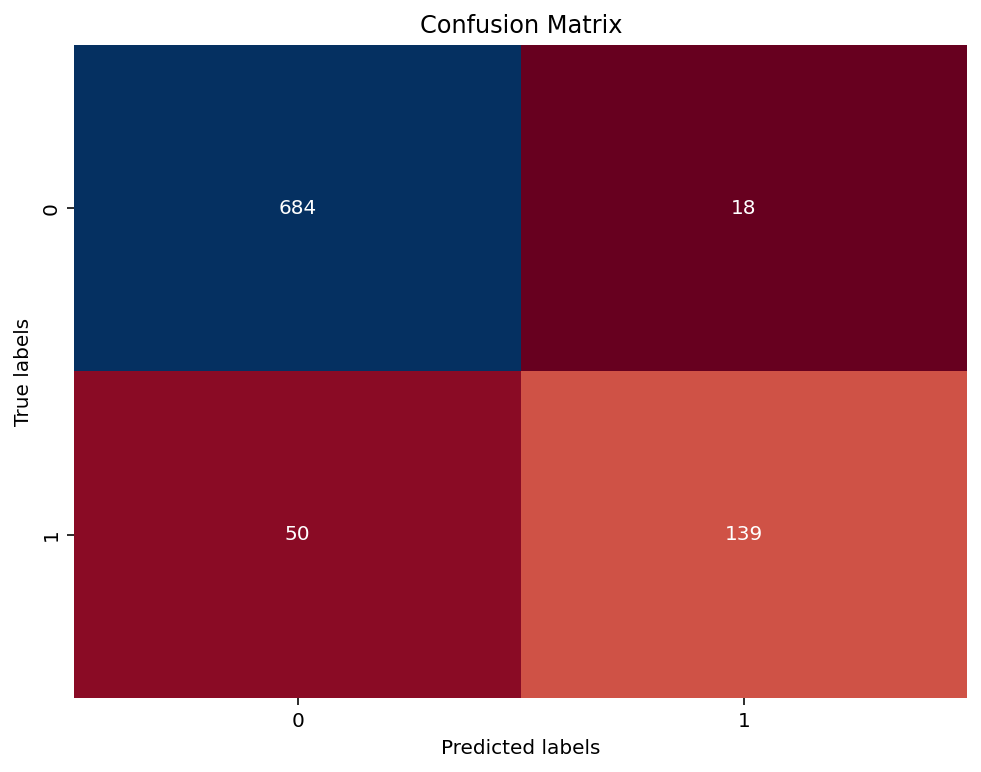

In [119]:
# confusion matrix
conf_matrix = confusion_matrix(test_data['ordered'], predictions)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'RdBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### ROC Curve AUC 

In [120]:
# get predictions
y_probs = predictor.predict_proba(test_data)[1] 
y_true = test_data['ordered'].values

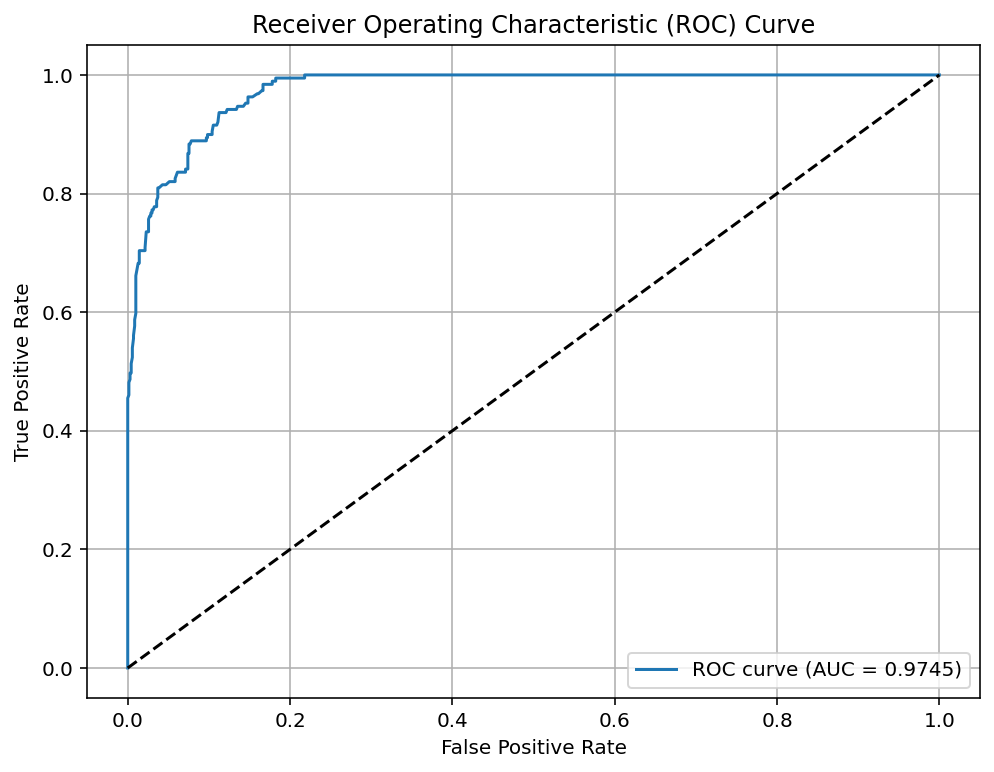

In [116]:
# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Precision Recall Curve

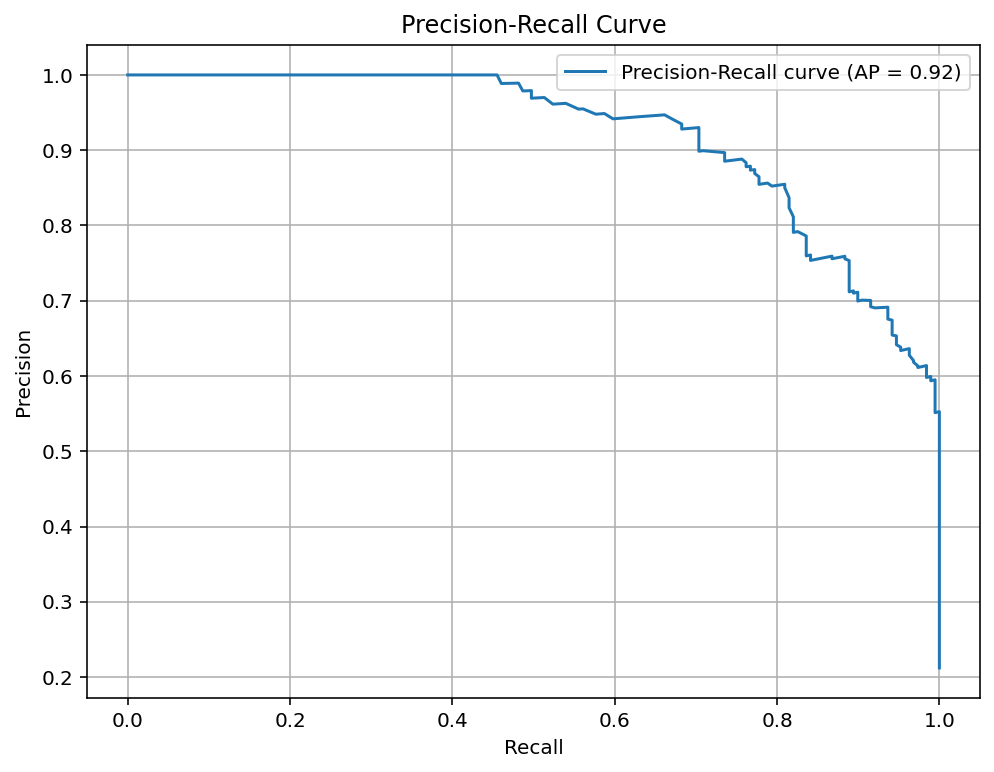

In [122]:
# precision recall curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)
average_precision = average_precision_score(y_true, y_probs)

# plot precision recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Gain Curve

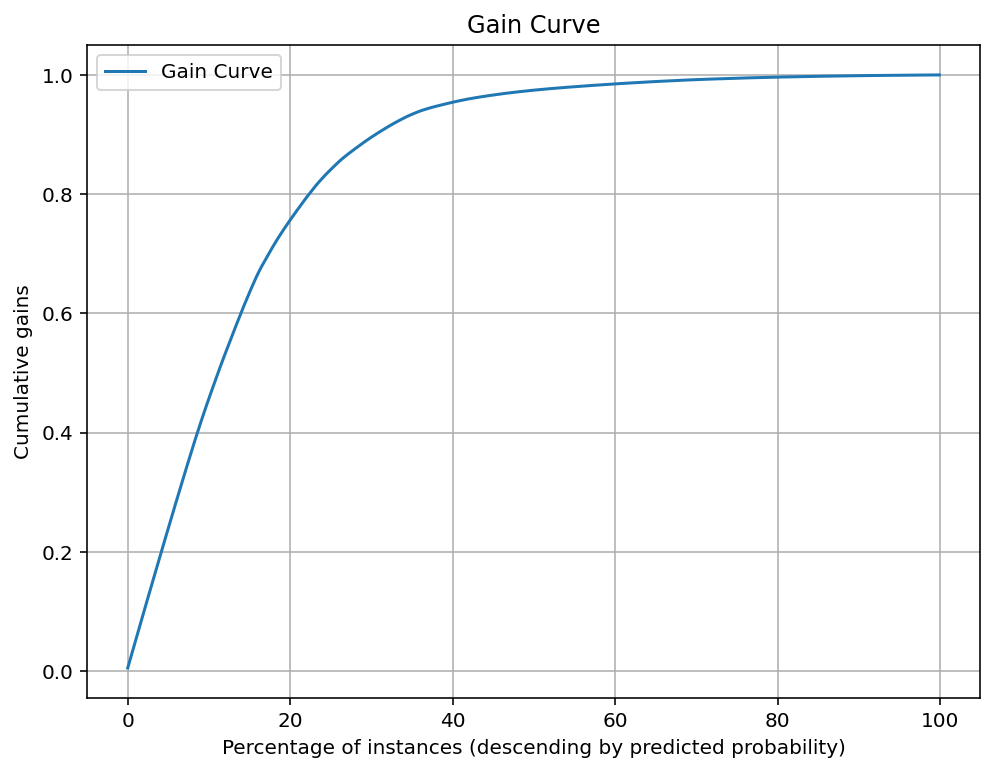

In [123]:
# gain curve
gains = np.cumsum(np.sort(y_probs)[::-1]) / np.sum(y_probs)
percentile = np.arange(0, len(gains)) / len(gains) * 100

# plot gain curve
plt.figure(figsize=(8, 6))
plt.plot(percentile, gains, label='Gain Curve')
plt.xlabel('Percentage of instances (descending by predicted probability)')
plt.ylabel('Cumulative gains')
plt.title('Gain Curve')
plt.legend()
plt.grid(True)
plt.show()